## Описание проекта

В мобильном приложении "Ненужные вещи", где пользователи продают свои ненужные вещи, размещая их на доске объявлений, необходимо выделить группы пользователей, которые различаются по метрикам:
1. retention rate,
2. время, проведённое в приложении,
3. частота действий,
4. конверсия в целевое действие — просмотр контактов.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Данные предоставлены Яндекс.Практикум и содержаться в двух файлах:
- https://code.s3.yandex.net/datasets/mobile_soures.csv
- https://code.s3.yandex.net/datasets/mobile_dataset.csv

До выплнения проекта доступны сведения о содержащихся в файлах данных:

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
-`contacts_call` — пользователь позвонил по номеру телефона на карточке объявления-
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

В рамках проекта необходимо выполнить следующие работы:

- **Провести исследовательский анализ данных**
- **Сегментировать пользователей на основе действий**
- **Проверить статистические гипотезы**
    1. *Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.*
    2. *Сформулировать собственную гипотезу. Дополнить её нулевой и альтернативной гипотезами. Проведите статистический тест.*
- **По итогам исследования подготовить презентацию**. Для создания презентации можно использовать любой удобный инструмент, но отправить презентацию нужно обязательно в формате pdf, прикрепив ссылку на файл в основном проекте.

### Декомпозиция

### Импорт библиотек и загрузка данных.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math as mth
import plotly.express as px
from datetime import datetime, timedelta
import math
import scipy.stats as stats

In [ ]:
#открываем файл:
try:
    dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
    sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
except:
    dataset = pd.read_csv('mobile_dataset.csv')
    sourсes = pd.read_csv('mobile_soures.csv')

## Предобработка данных

### Предобработка данных по обоим файлам.

In [ ]:
# Проверка пропусков
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
# Проверка пропусков
sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Пропусков значений в обоих датасетах нет.

In [ ]:
# Приведем в соответствие тип данных в столбце "event.time"
dataset['event.time'] = pd.to_datetime(dataset['event.time'])
# dataset.info() # проверка

In [ ]:
# Изменим названия столбцов в датасете "dataset"
dataset.columns = ['event_time', 'event_name', 'user_id']

In [ ]:
# Изменим названия столбцов в датасете "sourсes"
sourсes.columns = ['user_id', 'source']

In [ ]:
# проверка на дубликаты
for df in [dataset, sourсes]:
    display(df.duplicated().sum())

0

0

Дубликатов нет

### Предобработка по dataset

In [ ]:
dataset.info()
#, sourсes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Уникальные значения в колонке события 'event_name'
dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

В описании данных задания указано, что одно событие — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления может быть обозначено двумя способами: `"contacts_show"` и `«show_contacts»`. Тимлид пояснил, что это связано с загрузкой данных с разных платформ, поэтому их необходимо объеденить.

In [ ]:
# Приведение событий “contacts_show» и «show_contacts» к «contacts_show»
def rename(i):
    if i == 'show_contacts':
        new_name = 'contacts_show'
        return new_name
    return i

dataset['event_name'] = dataset['event_name'].apply(rename)

In [ ]:
# Уникальные названия событий после переименования
dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

In [ ]:
# Количество событий в наблюдаемый период
t = dataset['event_name'].value_counts()
t

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

Для единообразия вывода графиков применим функцию вывода графиков, разработанную ранее.

In [ ]:
# функция для вывода гистограммы, чтобы однообразно выводить графики.
def my_bar(df, x, y, title, y_title):
    fig = px.bar(df, x=x, y=y)
    fig.update_xaxes(tickangle=-90, tickmode = 'linear')

    fig.update_layout(title=title,
                      yaxis_title=y_title,
                      margin=dict(l=0, r=0))
    fig.show()

In [ ]:
my_bar(dataset['event_name'].value_counts(), dataset['event_name'].value_counts().index, dataset['event_name'].value_counts(),
      'Распределение количества событий', 'Количество событий')

In [ ]:
# Количество уникальных пользователей
dataset['user_id'].nunique()

4293

In [ ]:
# Распределение событий по датам
t = dataset.pivot_table(index= dataset['event_time'].dt.date, aggfunc={'user_id':'nunique'})

In [ ]:
my_bar(t, t.index, t['user_id'],
      'Распределение количества пользователей по датам', 'Количество событий')

### Предобработка по sources

In [ ]:
sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [ ]:
# Количество уникальных пользователей в sourсes
sourсes['user_id'].nunique()

4293

In [ ]:
# Количество источников
sourсes['source'].nunique()

3

In [ ]:
# Оригинальные названия источников
sourсes['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

Перед переходом к следующему этапу исследования, необходимо проверить наличие пользователей с двумя источниками.

In [ ]:
# Проверка на отсутствие общих элементов
yandex_set = set(df[df['source']=='yandex']['user_id'])
google_set = set(df[df['source']=='google']['user_id'])
other_set = set(df[df['source']=='other']['user_id'])

print(
    'yandex_set не имеет общих элементов c google_set: {}\n'
    'yandex_set не имеет общих элементов c other_set: {}\n'
    'google_set не имеет общих элементов c other_set: {}'.format(yandex_set.isdisjoint(google_set), yandex_set.isdisjoint(other_set), google_set.isdisjoint(other_set)))


yandex_set не имеет общих элементов c google_set: True
yandex_set не имеет общих элементов c other_set: True
google_set не имеет общих элементов c other_set: True


In [ ]:
#Распределение пользователей по источникам
t = sourсes.pivot_table(index= sourсes['source'], aggfunc={'user_id':'nunique'}).sort_values('user_id', ascending=False)
t.sort_values('user_id', ascending=False) #.sort_values('')

,user_id
source,
yandex,1934
other,1230
google,1129


In [ ]:
my_bar(t, t.index, t['user_id'],
      'Распределение количества пользователей по источникам', 'Количество пользователей')

### Результаты предобработки данных

Данные, находящиеся в двух датасетах загружены и проверены на соответствие условиям задания.

Выполнены следующие работы по обработки данных:
- Приведены в соответствия правилам Pandas названия колонок в обоих датасетах;
- Проведена проверка на дубликаты. Дубликаты отсутствуют;
- В datset объедены события “contacts_show» и «show_contacts». События приведены к общему событию «contacts_show».
- Рассмотрены распределения данных внутри датасетов. Аномалий не выявлено.

**Данные готовы к дальнейшим исследования**

## Исследовательский анализ данных¶

### Подготовительные работы

#### Объединение двух сетов

Для дальнейшей работы по исследованию данных необходимо объеденить данные, находящиеся в двух сетах:

In [ ]:
df = dataset.merge(sourсes, on='user_id', how = 'right')
df

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
...,...,...,...,...
74192,2019-11-03 23:46:47.068179,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google
74193,2019-11-03 23:46:58.914787,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google
74194,2019-11-03 23:47:01.232230,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google
74195,2019-11-03 23:47:47.475102,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google


#### Проверки после объединения

In [ ]:
# Проверка на дубликаты
df.duplicated().sum()

0

In [ ]:
# проверка на пропуски, соответствие типов
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


После объединения таблиц важно убедиться, что не возникло пользователей с двойным источником.

In [ ]:
# Проверка на отсутствие общих элементов
yandex_set = set(df[df['source']=='yandex']['user_id'])
google_set = set(df[df['source']=='google']['user_id'])
other_set = set(df[df['source']=='other']['user_id'])

print(
    'yandex_set не имеет общих элементов c google_set: {}\n'
    'yandex_set не имеет общих элементов c other_set: {}\n'
    'google_set не имеет общих элементов c other_set: {}'.format(yandex_set.isdisjoint(google_set), yandex_set.isdisjoint(other_set), google_set.isdisjoint(other_set)))


yandex_set не имеет общих элементов c google_set: True
yandex_set не имеет общих элементов c other_set: True
google_set не имеет общих элементов c other_set: True


### Исследование поведения пользователей в рамках каждой метрики

#### Анализ пользовательской активности.

Рассмотрим пользовательскую активность с нескольких ракурсов:

- Какие события пользователи генерируют и в каких пропорциях?

In [ ]:
# повторим график Количество событий в наблюдаемый период
t = df['event_name'].value_counts()
t

tips_show        34206
photos_show       9470
search            6485
advert_open       5002
contacts_show     3656
map               3256
favorites_add     1222
tips_click         720
contacts_call      541
Name: event_name, dtype: int64

In [ ]:
my_bar(t, t.index, t,
      'Распределение количества событий', 'Количество событий')

- Сколько каждый пользователь "сгенерировал" событий.


In [ ]:
t = df.pivot_table(index='user_id', aggfunc={'event_name':'count'}) #.sort_values('event_name', ascending=False)
t.sample(n=5)

,event_name
user_id,
aa781cfc-dd2f-4e74-80a3-77adda99ba55,5
726f4022-8e57-42c5-9bb8-97e83b00d624,23
fd9b3591-9dd3-48c4-804d-cbcbb9a3b8da,13
d63a05c1-9ef2-4214-9716-edaa965f6eb4,16
ac442fb7-b464-4625-b31c-d86600a3aa5f,16


Поисследуем как внутри этого массива данных распределились значения:

In [ ]:
t.describe()

,event_name
count,4251.000000
mean,15.186544
std,17.775218
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,132.000000


Видимо есть выбросы. Поищем повнимательнее. Посмотрим `quantile(0.99)` за чертой которого 1 процент пользователей приложения "Ненужные вещи".

In [ ]:
q = int(t.quantile(0.99))
q

96

Нужно отбросить пользователей, которые "сгенерировали" более 132 событий. Мы расстанемся с 1% пользователей. Пользователи в разы превышающие своей активностью основную массу - подозрительны, и могут исказить картину поведения для нашего исследования.

In [ ]:
t = t[t['event_name'] <= q]

In [ ]:
df = df[df['user_id'].isin(t.index)]

Посмотрим на гистограме, как выглядит распределение пользователей по количеству событий ими "сгенерированными"

In [ ]:
t

,event_name,0
user_id,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,event_name
00157779-810c-4498-9e05-a1e9e3cedf93,71,event_name
00463033-5717-4bf1-91b4-09183923b9df,10,event_name
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,event_name
00551e79-152e-4441-9cf7-565d7eb04090,8,event_name
...,...,...
ff82c7c7-16d6-44b1-833b-a217747b0b02,52,event_name
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17,event_name
ffc01466-fdb1-4460-ae94-e800f52eb136,7,event_name


In [ ]:
t.index

Index(['0001b1d5-b74a-4cbf-aeb0-7df5947bf349',
       '00157779-810c-4498-9e05-a1e9e3cedf93',
       '00463033-5717-4bf1-91b4-09183923b9df',
       '004690c3-5a84-4bb7-a8af-e0c8f8fca64e',
       '00551e79-152e-4441-9cf7-565d7eb04090',
       '00554293-7e00-4122-b898-4e892c4a7c53',
       '005fbea5-2678-406f-88a6-fbe9787e2268',
       '00653802-5ff1-4071-bc17-347fc4cef569',
       '006a32d4-ee10-40dc-b237-11e0fde81cbc',
       '006f6ced-225b-4f9c-9f17-23404bc6835f',
       ...
       'fee3ba1c-16f4-46f7-bf56-4bf80cc4e2f5',
       'fee79c65-d57e-42dc-9f3c-bfa69717eb2d',
       'ff1554b5-919e-40b1-90bb-ee1f7f6d5846',
       'ff24f3a3-d3fe-4d36-838a-3a29548e6c91',
       'ff5c152c-bd63-4797-8fa2-29987199e76d',
       'ff82c7c7-16d6-44b1-833b-a217747b0b02',
       'ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07',
       'ffc01466-fdb1-4460-ae94-e800f52eb136',
       'ffcf50d9-293c-4254-8243-4890b030b238',
       'ffe68f10-e48e-470e-be9b-eeb93128ff1a'],
      dtype='object', name='user_id', length=421

In [ ]:
t = t.groupby(by='event_name').index.agg('nunique')

AttributeError: ignored

In [ ]:
my_bar(t, t['event_name'], t.index.nunique(),
      'Распределение количества событий', 'Количество событий')

ValueError: ignored

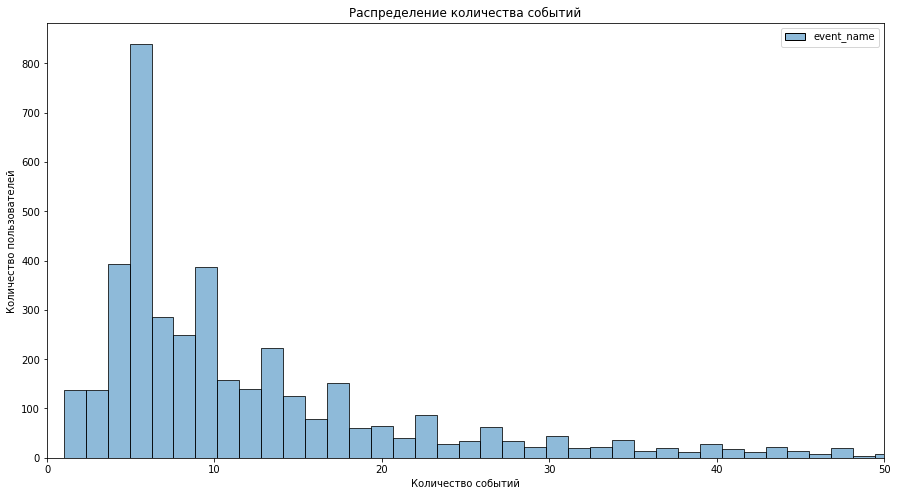

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(t, bins=100)
plt.title('Распределение количества событий')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.xlim(0, 50)
plt.show()

In [ ]:
t.describe()

,event_name
count,4251.000000
mean,15.186544
std,17.775218
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,132.000000


Если отбросить 1% самых активных пользователей, то распределение станет более равноменрным.

In [ ]:
# Безжалостно отбрасываем "гиперактивных" пользователей, они могут внести неточности в наши выводы - это нехарактерные пользователи.
df = df[df['user_id'].isin(t.index)]

Рассмотрим данные еще с одной стороны. Распределение активности пользователей по дням и часам внутри дня:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64558 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  64558 non-null  datetime64[ns]
 1   event_name  64558 non-null  object        
 2   user_id     64558 non-null  object        
 3   source      64558 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.5+ MB


In [ ]:
# сформируем внутри df две дополнительых колонки 'event_date' и 'event_hour' для формирования распределения по дням и часам
df['event_date'] = df['event_time'].dt.date
df['event_hour'] = df['event_time'].dt.hour

# для удобства восприятия зададим порядок метрик в данных
df = df[['user_id', 'event_name', 'event_date', 'event_hour','event_time', 'source']]

In [ ]:
df.head(1)

,user_id,event_name,event_date,event_hour,event_time,source
0,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:00:00.431357,other


Cформируем тепловую карту "heatmap" для наших данных, подготовив групировки по 'event_date', 'event_hour', добавив в агрегирующую функцию количество уникальных пользователей в этот час дня наблюдения.

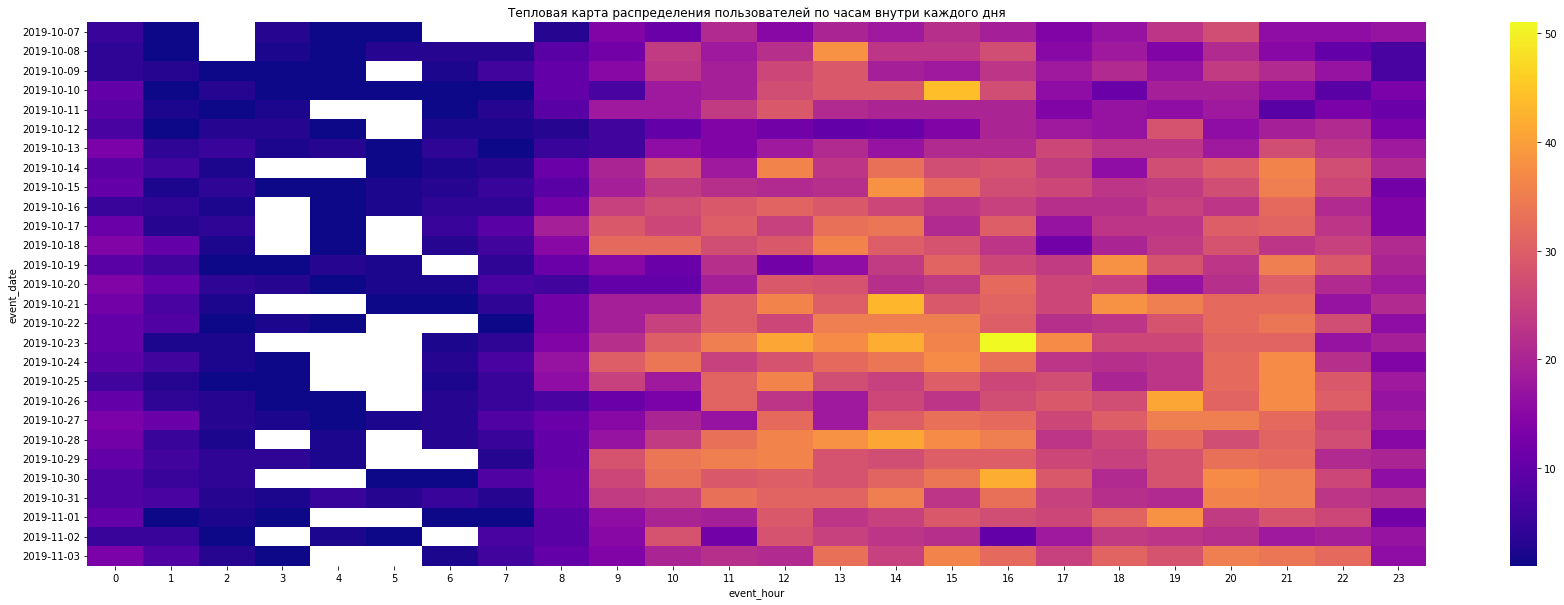

In [ ]:
date_time = df.groupby(['event_date', 'event_hour']).agg({'user_id':'nunique'}).reset_index()
# date_time
plt.figure(figsize=(30, 10))
sns.heatmap(date_time.pivot('event_date', 'event_hour', 'user_id'), cmap='plasma') #
plt.title('Тепловая карта распределения пользователей по часам внутри каждого дня')
plt.show()


Тепловая карта достаточно обычна - низкая активность пользователей ночью, высокая днем, ночью есть часы, когда активность нулевая.
Обращает на себя внимание пропуски данных с двух часов ночи до семи утра, такое положение вещей характерно, если все пользователи "Ненужных вещей" проживают в одном часовом поясе. В легенде учебной работы не описан регион выгруженных данных. Если в выгруженных данных не один регион - нужно бить тревогу.

#### Наблюдения, выводы и рекомендации.

После объединения двух сетов еще раз был проверен созданный сет на наличие дубликатов, пропусков и причасность пользователей к нескольким источникам. Кроме того, проведен предварительный анализ поведения пользователей по "генерированным" ими событиям, по датам, по часам внутри дня и выявлено количество пользователей "генерировавших" разное количество событий. По результатам последненго наблюдения отброшено из дальнейшего эксперимента 1% необычайно активных пользователей, "сгенерировавших" более 132 событий - `quantile(0.99)`.

Анализ тепловой карты выявил проблему - отсутствие пользователей в ночные часы. Эту информацию необходимо сообщить в маркетинговый и технический отдел, так как, возможно, в это время проводятся работы на сервере.

### Исследование поведения пользователей в рамках каждой метрики

Рассмотрим за какой период у нас есть данные.

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source
69385,8ae13794-3867-4398-962a-89ef979d4807,tips_show,2019-10-31,13,2019-10-31 13:08:44.662795,google


In [ ]:
display(f'В выгрузке представлены события за период с {df["event_time"].min()} по {df["event_time"].max()}')
display(f'Выборка в днях составляет {df["event_time"].max()-df["event_time"].min()}')

'В выгрузке представлены события за период с 2019-10-07 00:00:00.431357 по 2019-11-03 23:56:57.041825'

'Выборка в днях составляет 27 days 23:56:56.610468'

### Коэффициент удержания - retention rate
#### Адоптация функций расчета retention rate, разработанных в учебном проекте Юнит-Экономике.

В качестве функции расчета `retention rate` предложено использовать функцию, разработанную в проекте "Юнит-экономика" - "Анализ работы по привлечению клиентов развлекательного приложения". Эти функции потребуют небольшой доработки в части приведения в соответствие названия столбцов.

Сначала доработаем функцию подсчета профилей. Эта функция добавляет к ID пользователя время первого посещения, а также источник с которого пришел посетитель при первом посещении приложения:

In [ ]:
def get_profiles(sessions):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения event_time и source
    # столбец с временем первого посещения назовём first_ts
    # от англ. first timestamp — первая временная отметка
    profiles = (
        sessions.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first', 'source': 'first'})
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день недели, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['week'] = profiles['first_ts'].astype('datetime64[W]')

    return profiles
# Вызовем функцию get_profiles(), чтобы составить профили пользователей по данным сессий из датафрейма df:

profiles = get_profiles(df)
profiles.head()


,user_id,first_ts,source,dt,week
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-03
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19,2019-10-17
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01,2019-10-31
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18,2019-10-17
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25,2019-10-24


Функция `get_profiles` работает с новыми данными после доработки.

Имея готовые профили пользователей, легко узнать количество привлечённых каждым источником посетителей. Достаточно сгруппировать профили по источнику и посчитать количество уникальных ID.

In [ ]:
profiles.groupby('source').agg({'user_id': 'nunique'})


,user_id
source,
google,1119
other,1220
yandex,1912


Можно построить график, отображающий динамику привлечения новых пользователей по каждому из источников. Применим метод plot()

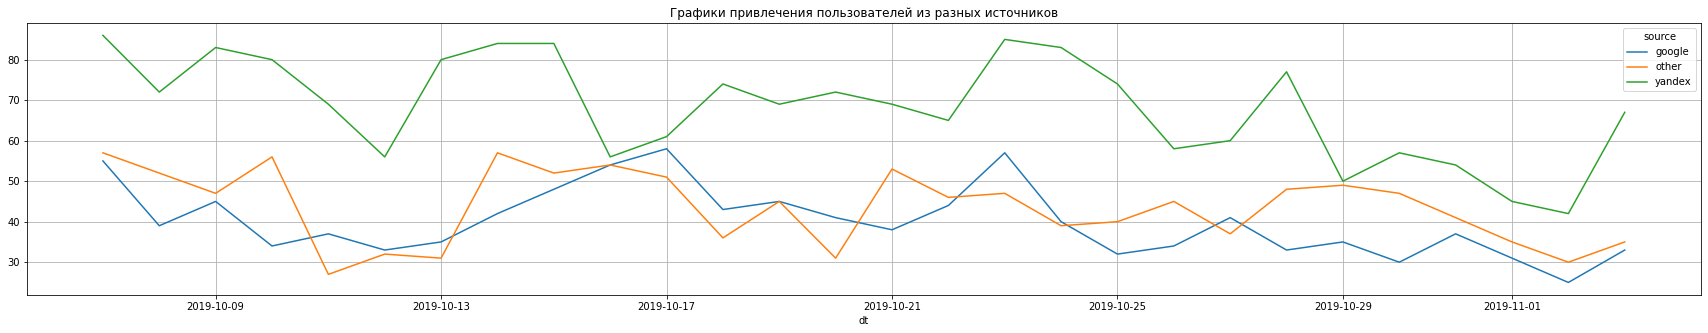

In [ ]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='source',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(30, 5), grid=True)
plt.title('Графики привлечения пользователей из разных источников')

plt.show()


График наглядно демонстрирует, что привлечение новых пользователей с Яндекса во все дни предоставленного нам периода выше, чем из других двух каналов. Прогоняя этот факт через ключевые метрики заказанные нам в исследовании возможно выделение либо на 2е подгруппы (Яндекс - НеЯндекс), либо на три группы (Яндекс-Гугл-Другие)

Для проведения исследований адоптируем к нашим условиям функцию, разработанную в рамках выполнения проекта "Анализ работы по привлечению клиентов развлекательного приложения".

Доработка также требует приведения в соответствие названий переменных и столбцов датасетов.

Функция `get_retention` разбивает на кагорты пользователей, подсчитывает количество пользователей в каждый день после первого посещения в каждой кагорте. На выходе расчитывает `retention rate` в каждый день для каждой кагорты.

В качестве аргументов функции поступают профиль, расчитанный функцией `get_profiles`, датасет, содержащий данные о всех посещениях, горизонт наблюдений, и информация о игнорировании горизонта наблюдения.

В качестве выходных параметров - два датасета - Таблицы с названием когорты, численностью кагорты и распределением  `retention rate` по дням жизни. Первая таблица сырая, вторая - полная.

Адоптируем к нашим условиям функцию, разработанную в рамках выполнения проекта "Анализ работы по привлечению клиентов развлекательного приложения"

In [ ]:
observation_date = df["event_time"].max()
df["event_time"].max()

Timestamp('2019-11-03 23:56:57.041825')

In [ ]:
horizon_days =14
#from datetime import datetime, timedelta

In [ ]:
last_suitable_acquisition_date = observation_date

In [ ]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'event_time']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped


Сырыми таблицами не пользуемся и при выводе из функции их игнорируем

In [ ]:
_ , result_grouped = get_retention(
    profiles, df, observation_date, horizon_days, ignore_horizon=False)

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



Функции доработаны и годны к эксплуатации

#### Исследование поведения пользователей в части коэфф. удержания

В качестве аргументов функции приняли:

- Дата наблюдения - максимальная (самая поздняя) дата события, представленного в данных.

Выбрана таким образом, чтобы максимально использовать представленные данные
- Горизонт наблюдений - 14 дней

(разделил на пополам, чтобы было как можно больше кагорт с полными данными).
- Количество кагорт с полными данными получилось при таком выборе - 14.

Нужно будет большее количество, так как я планирую исследования по дням недели. Выходных дней за 2е недели всего четыре, а для исследования (выделения сементов) нужно разнообразие. В качестве метрики планирую использовать удержание на 14 день.


In [ ]:
result_grouped

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2019-10-07,198,1.0,0.121212,0.085859,0.106061,0.040404,0.040404,0.055556,0.070707,0.045455,0.035354,0.035354,0.025253,0.025253,0.040404
2019-10-08,163,1.0,0.141104,0.116564,0.042945,0.042945,0.061350,0.042945,0.061350,0.049080,0.036810,0.049080,0.018405,0.024540,0.030675
2019-10-09,175,1.0,0.074286,0.057143,0.057143,0.068571,0.068571,0.057143,0.068571,0.057143,0.028571,0.017143,0.028571,0.028571,0.051429
2019-10-10,170,1.0,0.076471,0.088235,0.058824,0.082353,0.058824,0.052941,0.041176,0.064706,0.023529,0.017647,0.041176,0.035294,0.029412
2019-10-11,133,1.0,0.082707,0.112782,0.090226,0.075188,0.067669,0.075188,0.045113,0.015038,0.037594,0.030075,0.030075,0.045113,0.030075
2019-10-12,121,1.0,0.123967,0.157025,0.057851,0.057851,0.082645,0.057851,0.074380,0.066116,0.049587,0.057851,0.033058,0.074380,0.033058
2019-10-13,146,1.0,0.116438,0.061644,0.047945,0.061644,0.047945,0.041096,0.047945,0.047945,0.047945,0.034247,0.041096,0.041096,0.041096
2019-10-14,183,1.0,0.109290,0.092896,0.098361,0.076503,0.065574,0.049180,0.032787,0.071038,0.038251,0.027322,0.038251,0.016393,0.060109
2019-10-15,184,1.0,0.130435,0.081522,0.076087,0.048913,0.048913,0.070652,0.065217,0.059783,0.021739,0.032609,0.032609,0.027174,0.038043


Воспринимать эту информацию в табличном виде трудно, поэтому сторим тепловую таблицу

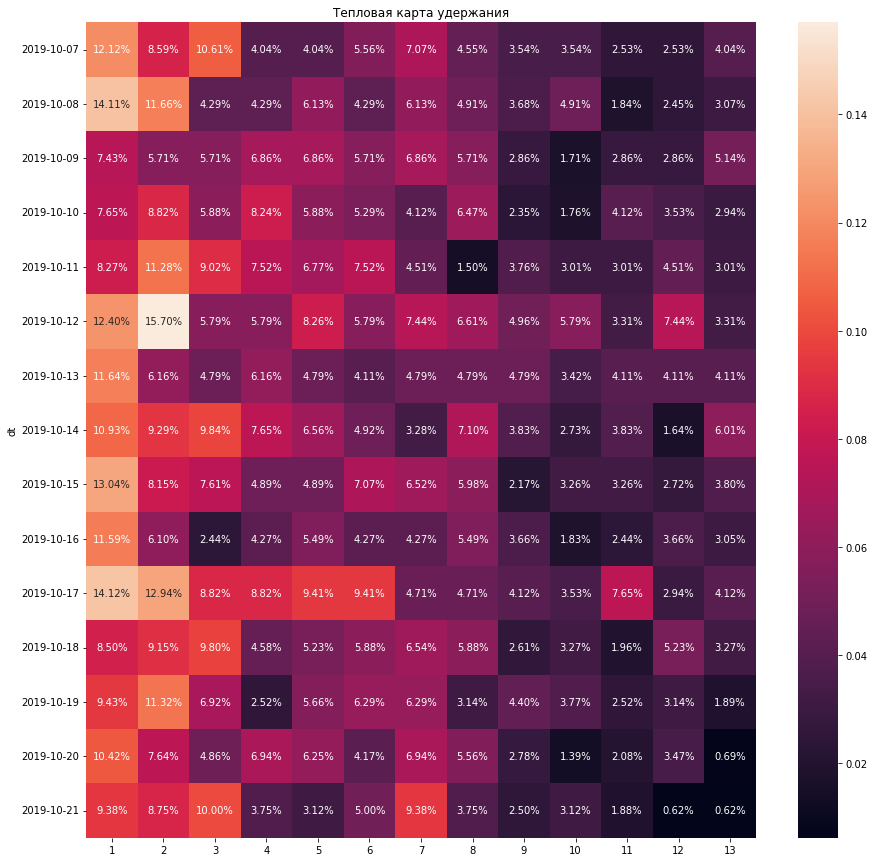

In [ ]:
# строим хитмэп

plt.figure(figsize=(15, 15))  # задаём размер графика
sns.heatmap(
    result_grouped.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()



Тепловой график тоже не сильно удивил:

- Некоторые кагорты, например 2019-10-17 до шестого дня имеют более высокий коэф.удержания, чем в других кагортах. А кагорты 2019-10-12 и 2019-10-14 имеют выбросы в 13 и 14 день. Какую либо кагорту выделить невозможно.

Такой тепловой график нам поможет при сегментировании для сравнения выделенных сегментов. А пока отметим - ***поведение пользователей обчное*** для пользователей приложения "Ненужные вещи".

Еще один график, демонстрирующий примерно тоже.

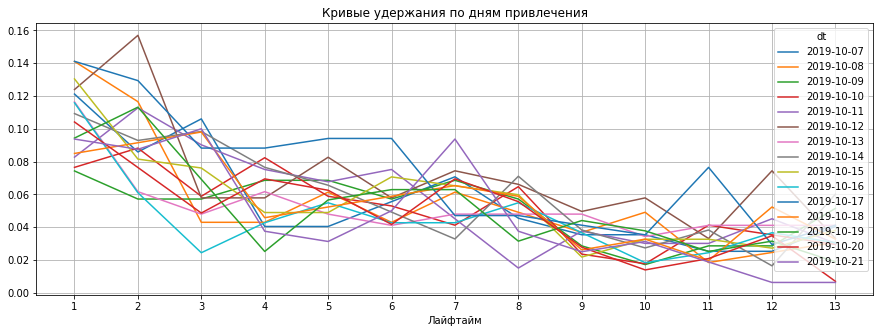

In [ ]:
report = result_grouped.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()


Малоинформативный график.

retention rate на второй день для разных кагорт показывает значения от 0.074286 до 0.141176 и за 14 дней в разных кагортах падает до 0.051429 - 0.006250. Падение неравноменное - есть выплески в некоторых кагортах.

#### Исследование поведения пользователей с помощью созданных функций в части дня недели первого посещения.

Посмотрим, как влияет день недели первого посещения на удержание пользователей:

- разделим пользователей на два временных датасета.

Придется добавить в `df` еще один столбец - "день недели"

In [ ]:
df['weekofday'] = df['event_time'].dt.dayofweek

надо напомнить, что дни недели после работы функции распределены следующим образом:

0- понедельник, 1 - вторник, 2 - среда, 3 - четверг, 4 - пятница, 5 - суббота, 6- воскресенье

Готовим временные файлы для исследования удержание от дня первого посещения:

In [ ]:
t_5_6 = df.query('weekofday == 5 or weekofday==6')

В этой переменной `t_5_6` отобраны все посетители, совершившие события в субботу-воскресенье

In [ ]:
profiles_5_6 = get_profiles(t_5_6)

В профиле `profiles_5_6` отобраны пользователи совершившие первую активность в выходные дни

In [ ]:
t_0_1_2_3_4 = df.query('weekofday == 0 or weekofday==1 or weekofday==2 or weekofday==3 or weekofday==4')

В этой `t_0_1_2_3_4` переменной отобраны все посетители, совершившие события в будние дни

In [ ]:
profiles_0_1_2_3_4 = get_profiles(t_0_1_2_3_4)

В профиле `profiles_0_1_2_3_4` отобраны пользователи совершившие первую активность в будние дни

In [ ]:
# для суботне-воскресных пользователей
_ , result_grouped_5_6 = get_retention(
    profiles_5_6, df, observation_date, horizon_days, ignore_horizon=False)

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



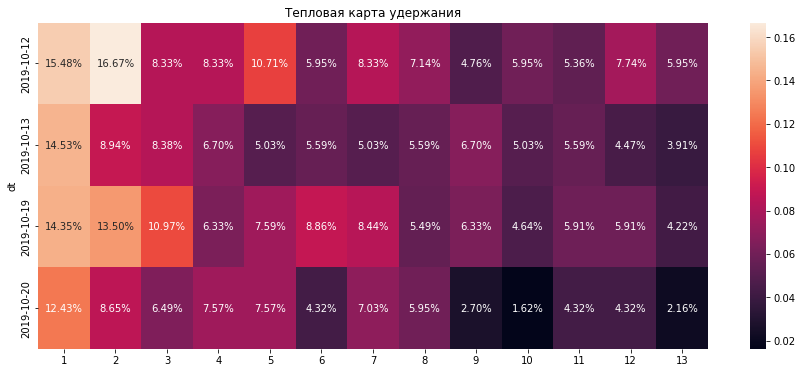

In [ ]:
# строим хитмэп

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    result_grouped_5_6.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

In [ ]:
# для будничных пользователей
_ , result_grouped_0_1_2_3_4 = get_retention(
    profiles_0_1_2_3_4, df, observation_date, horizon_days, ignore_horizon=False)

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [ ]:
result_grouped_0_1_2_3_4

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2019-10-07,198,1.0,0.121212,0.085859,0.106061,0.040404,0.040404,0.055556,0.070707,0.045455,0.035354,0.035354,0.025253,0.025253,0.040404
2019-10-08,163,1.0,0.141104,0.116564,0.042945,0.042945,0.061350,0.042945,0.061350,0.049080,0.036810,0.049080,0.018405,0.024540,0.030675
2019-10-09,175,1.0,0.074286,0.057143,0.057143,0.068571,0.068571,0.057143,0.068571,0.057143,0.028571,0.017143,0.028571,0.028571,0.051429
2019-10-10,170,1.0,0.076471,0.088235,0.058824,0.082353,0.058824,0.052941,0.041176,0.064706,0.023529,0.017647,0.041176,0.035294,0.029412
2019-10-11,133,1.0,0.082707,0.112782,0.090226,0.075188,0.067669,0.075188,0.045113,0.015038,0.037594,0.030075,0.030075,0.045113,0.030075
2019-10-14,221,1.0,0.131222,0.104072,0.117647,0.076923,0.076923,0.072398,0.040724,0.081448,0.049774,0.031674,0.045249,0.027149,0.067873
2019-10-15,198,1.0,0.136364,0.085859,0.080808,0.045455,0.045455,0.070707,0.060606,0.055556,0.025253,0.035354,0.035354,0.025253,0.035354
2019-10-16,167,1.0,0.113772,0.065868,0.029940,0.041916,0.053892,0.041916,0.041916,0.053892,0.035928,0.017964,0.023952,0.035928,0.029940
2019-10-17,177,1.0,0.141243,0.124294,0.090395,0.090395,0.101695,0.101695,0.056497,0.050847,0.039548,0.033898,0.073446,0.028249,0.039548


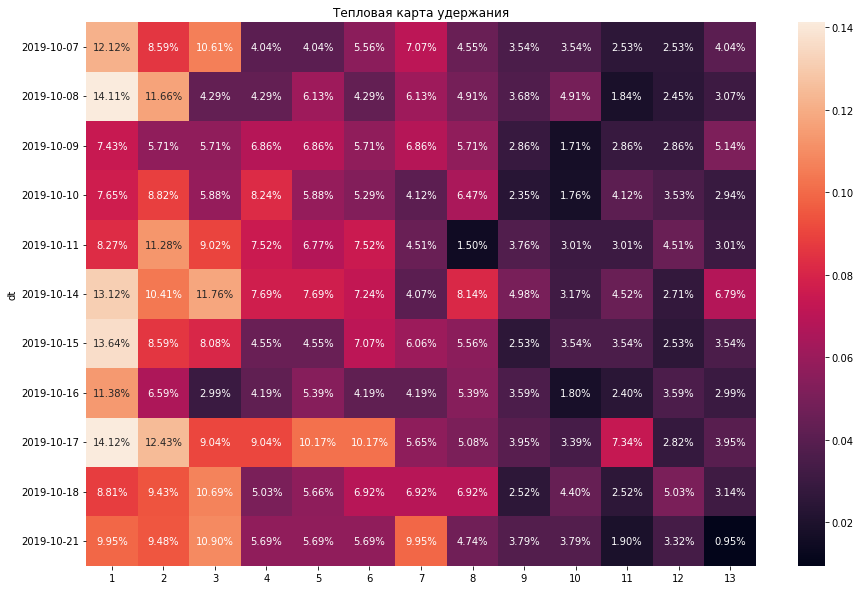

In [ ]:
# строим хитмэп

plt.figure(figsize=(15, 10))  # задаём размер графика
sns.heatmap(
    result_grouped_0_1_2_3_4.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Визуально `heatmap` с посетителями, первый раз посетившими приложение "Ненужные вещи" в выходные темнее, чем  `heatmap` с посетителями, первый раз посетившими в будни. Но визуальное сравнени не наш метод!

Сравним среднее удержание на ***четырнадцатый*** день для всех кагорт для обоих групп:

In [ ]:
# средний для всех кагорт коэффициент удержания на 14й день для посетителей приложения, зарегистрироваышихся на буднях
result_grouped_0_1_2_3_4[13].mean()

0.03596678235279784

In [ ]:
# средний для всех кагорт коэффициент удержания на 14й день для посетителей приложения, зарегистрироваышихся в выходные
result_grouped_5_6[13].mean()

0.040611417305958006

Средний для всех кагорт коэффициент удержания на 14й день для посетителей приложения, зарегистрироваышихся в выходные выше чем такой же коэфициент для посетителей приложения, первое посещение которых состоялось на буднях.

*Эти данные могут пригодиться нам при сегментации!*

#### Выводы и рекомендации

В разделе учебного проекта проведены следующие работы:
- Адоптированы к данным функции подсчета коэффициента удержания, разработанные ранее;
- Оценены общие показатели коэффициента удержания за 14 дневный период для ежедневных кагорт.
- Сравнены посетители, совершившие первое действие в приложении в выходные с посетителями , совершившие первое действие в приложении в будние дни.

***Выводы***:

- Коэффициенты `retention rate` в зависимости от кагорты ведут себя неравноменрно, но пресказуемо;
- Падают за 14 дней с 0.074286 до 0.006250 в зависимости от кагорты;
- Средние коэфф. удержания для 2х групп показали разницу - 0.03596678235279784 и 0.040611417305958006.

***Рекомендации***

- Для понимания статистической значимости этой разницы в дальнейшем необходимо провести Z-тест.

### Исследование времени, проведенном в приложении пользователями

#### Дополнительные расчеты

Перед началом исследования посмотрим, как изменились наши данные:

После добавления дополнительных столбцов в датасет, он стал иметь вид -

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday
27594,d2cfc339-7a5c-4063-b145-218216630a79,tips_show,2019-10-31,23,2019-10-31 23:20:46.610320,other,3


В полученных данных есть точное время начала события - `'event_time'` с точностью до милисекунды, но нет времени окончания сессии. Это время, когда пользователь вышел из приложения или утратил интерес, переключившись на своем устройстве в другую программу.
Поэтому нужно будет принять некоторые допущения:

- сессиями (активными действиями) пользователя будем считать сумму (разность) времени между действиями этого пользователя;
- если время между двуми действиями одного пользователя привышает ***30 минут*** предыдущая сесия заканчивается и начинается следующая;
- время между сесссиями считаем в секундах.

Возникнут некоторые дополнительные вычисления

In [ ]:
# Cоздадим столбец времени предыдущего действия пользователя
df['pre_action_time'] = df.groupby('user_id')['event_time'].shift()
#df['pre_action_time'].fillna(df['event_time'],inplace=True) # первые входы в приложение не имеют предыдущего события
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time
19888,b7c44ad0-e45e-42ae-b0db-8f23ee0b2a7c,favorites_add,2019-10-12,14,2019-10-12 14:40:24.804887,google,5,NaT


In [ ]:
df1 = df.copy()
df1 = df1.sort_values(['user_id', 'event_time'])
diff_timestamp = df.groupby('user_id')['event_time'].diff() / 1000
new_session = (diff_timestamp.isnull()) | (diff_timestamp > pd.Timedelta('30Min'))
df1['session_id'] = df1.loc[new_session, ['user_id', 'event_time']].groupby('user_id').rank(method='first').astype(int)
df1['session_id'] = df1['session_id'].fillna(method='ffill').astype(int)
df1['session_id'].unique()
diff_timestamp
new_session

0         True
1        False
2        False
3        False
4        False
         ...  
74192     True
74193    False
74194    False
74195    False
74196    False
Name: event_time, Length: 64558, dtype: bool

In [ ]:
df1 = df.copy()
#convert to datetimes
df1['event_time'] = pd.to_datetime(df1['event_time'])
#identify difference 30Min for each group with cumulative sum
g = (df1.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
#create counter of groups
df1['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
df1['session_id'].unique()
df1.head(20)
#df1.groupby('user_id')['session_id'].max()

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,session_id
0,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:00:00.431357,other,0,NaT,1
1,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:00:01.236320,other,0,2019-10-07 00:00:00.431357,1
2,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:00:07.039334,other,0,2019-10-07 00:00:01.236320,1
3,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:01:27.770232,other,0,2019-10-07 00:00:07.039334,1
4,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:01:34.804591,other,0,2019-10-07 00:01:27.770232,1
5,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:01:54.958298,other,0,2019-10-07 00:01:34.804591,1
6,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:02:01.354436,other,0,2019-10-07 00:01:54.958298,1
7,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:02:25.457498,other,0,2019-10-07 00:02:01.354436,1
8,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:02:30.856380,other,0,2019-10-07 00:02:25.457498,1
9,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:03:02.305654,other,0,2019-10-07 00:02:30.856380,1


In [ ]:
# Cоздадим столбец разницы времени предыдущего действия и текущего для всех пользователей
df['active_session'] = df['event_time'] - df['pre_action_time']
# df['active_session'].fillna('0',inplace=True)
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session
44940,e6f0a2cd-eba5-4cfe-8342-351ab22a60a2,favorites_add,2019-10-20,20,2019-10-20 20:19:15.927366,yandex,6,2019-10-20 20:14:58.461065,0 days 00:04:17.466301


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64558 entries, 0 to 74196
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_id          64558 non-null  object         
 1   event_name       64558 non-null  object         
 2   event_date       64558 non-null  object         
 3   event_hour       64558 non-null  int64          
 4   event_time       64558 non-null  datetime64[ns] 
 5   source           64558 non-null  object         
 6   weekofday        64558 non-null  int64          
 7   pre_action_time  60307 non-null  datetime64[ns] 
 8   active_session   60307 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(4), timedelta64[ns](1)
memory usage: 4.9+ MB


In [ ]:
# Пронумеруем сессии в сответствии с нашими допущениями
f = lambda t: t.diff().gt(pd.Timedelta('30T')).cumsum()
df['session_num'] = df.groupby('user_id')['event_time'].apply(f) + 1
#prevent SettingWithCopyWarning message from appearing
pd.options.mode.chained_assignment = None
df['active_session'].loc[(df['active_session'] > pd.Timedelta(30,'m'))] = np.nan
#t30 = pd.Timedelta(30,'m')
#df['active_session'].query('active_session > t30') = np.nan
df['active_session'].fillna('0',inplace=True)
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
61444,fbec9791-f909-4b30-b28c-b014e3aae66a,tips_click,2019-10-27,14,2019-10-27 14:09:51.149521,other,6,2019-10-27 14:09:21.288035,0 days 00:00:29.861486,1


Предварительные расчеты закончили, можно приступать к анализу.

#### Подсчет суммарного времени для каждого пользователя, проведенное в приложении

Вначале посмотрим сеесии каждого пользователя в разрезе их продолжительности во всем датасете

In [ ]:
t = df.groupby(['user_id','session_num'], as_index=False).agg({'active_session':'sum'})

In [ ]:
t

,user_id,session_num,active_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,0 days 00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,0 days 00:08:27.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,0 days 00:14:59.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,0 days 00:12:38.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,0 days 00:25:20.787329
...,...,...,...
9533,ffc01466-fdb1-4460-ae94-e800f52eb136,1,0 days 00:00:52.138456
9534,ffcf50d9-293c-4254-8243-4890b030b238,1,0 days 00:01:20.378132
9535,ffe68f10-e48e-470e-be9b-eeb93128ff1a,1,0 days 00:10:23.236163
9536,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2,0 days 00:12:35.480259


In [ ]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   user_id         9538 non-null   object         
 1   session_num     9538 non-null   int64          
 2   active_session  9538 non-null   timedelta64[ns]
dtypes: int64(1), object(1), timedelta64[ns](1)
memory usage: 223.7+ KB


In [ ]:
# cуммарная продолжительность сессий пользователей за весь период
t['active_session'].sum()

Timedelta('80 days 12:35:09.468477')

In [ ]:
# подсчет сессий с "нулевой" продолжительностью
t.query('active_session == "0 days 00:00:00"').count()

user_id           1954
session_num       1954
active_session    1954
dtype: int64

In [ ]:
print (df['user_id'].nunique(),'пользователей за указанный период совешили', \
       t ['session_num'].count(), 'событий и суммарно провели в приложении', t['active_session'].sum())

4251 пользователей за указанный период совешили 9538 событий и суммарно провели в приложении 80 days 12:35:09.468477


In [ ]:
t.describe()

,session_num,active_session
count,9538.000000,9538
mean,3.112497,0 days 00:12:09.430642532
std,3.989925,0 days 00:18:05.711550434
min,1.000000,0 days 00:00:00
25%,1.000000,0 days 00:00:21.032658750
50%,2.000000,0 days 00:05:24.695546500
75%,3.000000,0 days 00:16:30.197308
max,45.000000,0 days 05:21:58.296302


Посмотрим, как распределились пользователи по количеству проведенных сессий

In [ ]:
t.groupby('user_id')['session_num'].max()

user_id
0001b1d5-b74a-4cbf-aeb0-7df5947bf349    4
00157779-810c-4498-9e05-a1e9e3cedf93    6
00463033-5717-4bf1-91b4-09183923b9df    1
004690c3-5a84-4bb7-a8af-e0c8f8fca64e    6
00551e79-152e-4441-9cf7-565d7eb04090    3
                                       ..
ff82c7c7-16d6-44b1-833b-a217747b0b02    5
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07    2
ffc01466-fdb1-4460-ae94-e800f52eb136    1
ffcf50d9-293c-4254-8243-4890b030b238    1
ffe68f10-e48e-470e-be9b-eeb93128ff1a    3
Name: session_num, Length: 4251, dtype: int64

In [ ]:
my_bar(t.groupby('user_id')['session_num'], t.groupby('user_id')['session_num'].max(), t.groupby('user_id')['session_num'].max(),
      'Распределение количества пользователей по количеству сессий', 'Количество пользователей')

Большинство пользователей совершили 1, 2, 3 сессий. есть несколько выплесков 30 - 45 сессий, но их количество невелико и особого влияния на резултаты не окажет.

***Промежуточный вывод***

В среднем каждый пользователь в указанный период времени провел в приложении 12 минут за каждую сессию. Медиана периода нахождения пользователя в приложении - 5 минут несколько сдвинута в право, что можно объяснить наличием сессий с "нулевой" продолжительностью. Таких сессий 1954 шт. Скорее всего они возникли, когда пользователи в течении одной секунды нажимают на два разных окна "генерируя" два события с разницей во времени менее 1 секунды, кроме того я добавил нулей "брошенным сессиям".

#### Какие пользователи доходят до целевого действия

По условиям учебного проекта целевым действием является — просмотр контактов `'contacts_show'` в столбце `'event_name'`.

Для лучшего понимания характера взаимодействия пользователей с приложением "Ненужные вещи" выясним какие действия (генерация событий) совершали пользователи кликнувшие на `'contacts_show'`.

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
69508,1c8c7c78-9f15-4dee-8d88-b01d6a062a42,contacts_show,2019-10-31,14,2019-10-31 14:25:31.288320,google,3,NaT,0 days,1


In [ ]:
df['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search_4',
       'search_2', 'search_5', 'contacts_show', 'search_6', 'photos_show',
       'search_1', 'search_3', 'favorites_add', 'contacts_call',
       'search_7'], dtype=object)

In [ ]:
# Получим список user_id, совершивших целевое действие
t = df.query('event_name == "contacts_show"')['user_id']# Получили список user_id, совершивших целевое действие
# t

In [ ]:
df

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
0,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:00:00.431357,other,0,NaT,0 days 00:00:00,1
1,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:00:01.236320,other,0,2019-10-07 00:00:00.431357,0 days 00:00:00.804963,1
2,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:00:07.039334,other,0,2019-10-07 00:00:01.236320,0 days 00:00:05.803014,1
3,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:01:27.770232,other,0,2019-10-07 00:00:07.039334,0 days 00:01:20.730898,1
4,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:01:34.804591,other,0,2019-10-07 00:01:27.770232,0 days 00:00:07.034359,1
...,...,...,...,...,...,...,...,...,...,...
74192,d157bffc-264d-4464-8220-1cc0c42f43a9,map,2019-11-03,23,2019-11-03 23:46:47.068179,google,6,NaT,0 days 00:00:00,1
74193,d157bffc-264d-4464-8220-1cc0c42f43a9,advert_open,2019-11-03,23,2019-11-03 23:46:58.914787,google,6,2019-11-03 23:46:47.068179,0 days 00:00:11.846608,1
74194,d157bffc-264d-4464-8220-1cc0c42f43a9,tips_show,2019-11-03,23,2019-11-03 23:47:01.232230,google,6,2019-11-03 23:46:58.914787,0 days 00:00:02.317443,1
74195,d157bffc-264d-4464-8220-1cc0c42f43a9,advert_open,2019-11-03,23,2019-11-03 23:47:47.475102,google,6,2019-11-03 23:47:01.232230,0 days 00:00:46.242872,1


In [ ]:
# Выберем все строки датсета совершенные пользователями добравшихся до целевого действия
df_contacts_show = df[df['user_id'].isin(t)]

Посмотрим, какие действия (события) они совершали.

In [ ]:
t = df_contacts_show.rename(columns={'event_name': 'event_name_target'})# переименовать
t = t['event_name_target'] # выделить столбец
t = t.value_counts()
t

tips_show        8789
contacts_show    3656
photos_show      3412
search_1         1292
advert_open      1071
map               714
contacts_call     541
favorites_add     392
tips_click        246
search_5          191
search_4          127
search_2           89
search_3           87
search_6           66
search_7           27
Name: event_name_target, dtype: int64

In [ ]:
my_bar(t, t.index, t,
      'Распределение количества событий среди пользователей достигших целевого события', 'Количество событий')

In [ ]:
t1 = df['event_name'].value_counts()
t1

tips_show        34206
photos_show       9470
advert_open       5002
contacts_show     3656
search_1          3451
map               3256
favorites_add     1222
search_5           985
tips_click         720
search_4           636
contacts_call      541
search_6           451
search_3           442
search_2           315
search_7           205
Name: event_name, dtype: int64

Для удобства сравнения, объеденим две таблицы количества разных событий для всего датафрейма и количества разных событий для пользователей, достигших целевого события и добавим подсчет в долях:

In [ ]:
t1 = pd.concat([t1, t], axis=1)

In [ ]:
t1

,event_name,event_name_target
tips_show,34206,8789
photos_show,9470,3412
advert_open,5002,1071
contacts_show,3656,3656
search_1,3451,1292
map,3256,714
favorites_add,1222,392
search_5,985,191
tips_click,720,246
search_4,636,127


Для удобства добавим подсчет в долях:

In [ ]:
t1['ratio'] = t1['event_name']/t1.event_name.sum()
t1['ratio_target'] = t1['event_name_target']/t1.event_name_target.sum()

In [ ]:
t1['difference'] =t1['ratio'] - t1['ratio_target']

In [ ]:
t1

,event_name,event_name_target,ratio,ratio_target,difference
tips_show,34206,8789,0.529849,0.424589,0.105260
photos_show,9470,3412,0.146690,0.164831,-0.018141
advert_open,5002,1071,0.077481,0.051739,0.025742
contacts_show,3656,3656,0.056631,0.176618,-0.119987
search_1,3451,1292,0.053456,0.062415,-0.008960
map,3256,714,0.050435,0.034493,0.015943
favorites_add,1222,392,0.018929,0.018937,-0.000008
search_5,985,191,0.015258,0.009227,0.006031
tips_click,720,246,0.011153,0.011884,-0.000731
search_4,636,127,0.009852,0.006135,0.003716


Обращает на себя внимание большая разница (10,5%) между общей выборкой и выборкой достигших целевой отметки в разделе `tips_show` - пользователь увидел рекомендованные объявления.  Это говорит о том, что целевые посетители видят на 10% раз меньше рекомендованные объявления. Возможно, тех кто не дошел до целевого события сбило с толку рекомендованное объявление и завело не туда, где посетитель сможет выполнить целевую функцию приложения "Ненужные вещи".

***Промежуточная рекомендация***

Необходимо сообщить в технический отдел, о возможной плохой настройке показа рекомендованного объявления.

**Расчет времени прибывания пользователей, совершивших целевое действие.**

Предлагается сравнить среднее время использования приложения для пользователей достигших целевого события и пользователей не достигших этого события.

Разделим пользователей на 2 неравных массива:

In [ ]:
# Получим список user_id, совершивших целевое действие
t = df.query('event_name == "contacts_show"')['user_id'].unique()# Получили список user_id, совершивших целевое действие
# Выберем все строки датсета совершенные пользователями добравшихся до целевого действия
df_contacts_show = df[df['user_id'].isin(t)]

In [ ]:
df_contacts_show.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20700 entries, 121 to 74191
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_id          20700 non-null  object         
 1   event_name       20700 non-null  object         
 2   event_date       20700 non-null  object         
 3   event_hour       20700 non-null  int64          
 4   event_time       20700 non-null  datetime64[ns] 
 5   source           20700 non-null  object         
 6   weekofday        20700 non-null  int64          
 7   pre_action_time  19744 non-null  datetime64[ns] 
 8   active_session   20700 non-null  timedelta64[ns]
 9   session_num      20700 non-null  int64          
dtypes: datetime64[ns](2), int64(3), object(4), timedelta64[ns](1)
memory usage: 1.7+ MB


In [ ]:
# Получим список user_id, не совершивших целевое действие
t1 = df.query('event_name == "contacts_show"')['user_id'].unique()# Получили список user_id, совершивших целевое действие
#Выберем все строки датсета, совершенные пользователями добравшихся до целевого действия
df_no_contacts_show = df[~df['user_id'].isin(t1)]

In [ ]:
df_contacts_show.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
32400,570e1e48-5bfb-4c99-84b6-a10d9a15bf05,tips_show,2019-10-31,20,2019-10-31 20:30:23.828098,other,3,2019-10-31 20:30:03.082372,0 days 00:00:20.745726,11


In [ ]:
df_no_contacts_show.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
14052,aa448d5f-c1de-4baf-8e04-0715d6fbd292,tips_show,2019-10-10,15,2019-10-10 15:40:47.893529,yandex,3,2019-10-10 15:39:18.857297,0 days 00:01:29.036232,1


Найдем среднее время сессий пользователей для обеих групп

In [ ]:
#df_contacts_show['active_session'].mean()
pd.to_timedelta(pd.Series(df_contacts_show['active_session'])).mean()

Timedelta('0 days 00:01:53.696234574')

In [ ]:
#df_no_contacts_show.active_session.mean()
pd.to_timedelta(pd.Series(df_no_contacts_show['active_session'])).mean()

Timedelta('0 days 00:01:44.970527903')

In [ ]:
#df.active_session.mean()
pd.to_timedelta(pd.Series(df['active_session'])).mean()

Timedelta('0 days 00:01:47.768355098')


***Промежуточный вывод***

Время прибывания всех пользователей в одной сессии в отчетном периоде практически одинаково для всех пользователей - около 2х минут вне зависимости от события выполнил ли пользователь целевое действие или нет. Искать в этой метрике разные группы бессмыслено.

#### Выводы и рекомендации

При работе над этим разделом были выполненв следующие работы и получены результаты:
- сформированы новые столбцы датасета:
        pre_action_time - время предыдущего сеанса
        active_session - продолжительность сеанса
        session_num - номер сеанса каждого пользователя
        
- Выполнены расчеты среднего времени сессии, которое пользователь проводит в приложении - это около 12 минут.

Если этот параметр (метрика) будет расчитываться постоянно, то необходимо доработать выгрузку дополнительными данными о окончании сессии, так как в этом исследовании величина продолжительности сессии была вычислена на основании допущений о максимальной продолжительности сессии - 30 минут, что неприемлимо для постоянной метрики.
- При исследовании распределении видов событий между пользователями достигшими и недостигшими целевого события выявлено противоречие, что пользователи недостигшие целевого события реже пользовались (видели) рекомендованное объявление, что может говорить о плохой настройке рекомендаций и увода пользователей от целевого действия. Необходимо поставить в известность инженеров, ответственных за это для уточнения работы приложения.
- Время пребываня пользователей, совершивших и несовершивших целевое действие практически не отличается. И те и другие в среденм провели в одной сессии за отчетный период около 2х минут.   
    

### Частота действий

#### Часто встречающиеся события, сгенерированные пользователями в рассматриваемый период

Еще раз вернемся к гистограмме частоты событий. Сколько раз все пользователи сгенерировари каждое событие?

In [ ]:
t = df.rename(columns={'event_name': 'event_name_total'})# переименовать
t = t['event_name_total'] # выделить столбец
t = t.value_counts()
t

tips_show        34206
photos_show       9470
advert_open       5002
contacts_show     3656
search_1          3451
map               3256
favorites_add     1222
search_5           985
tips_click         720
search_4           636
contacts_call      541
search_6           451
search_3           442
search_2           315
search_7           205
Name: event_name_total, dtype: int64

In [ ]:
my_bar(t, t.index, t,
      'Распределение количества событий среди всех пользователей', 'Количество событий')

Обращает внимание, что целевое событие не на самом последнем месте, а кликанье по рекомендованному объявлению на предпоследнем месте, уступая лишь вызову по телефону из приложения, что хоть и важно, но некомфортно для пользователя. Предпоследнее место `tips_click` еще раз подтверждает плохую настройку вывода рекомендованных объявлений.

Рассмотрим каких и сколько событий нагенерировал каждый пользователь:

In [ ]:
t = df.pivot_table(index=['user_id'], columns='event_name' , aggfunc={'event_name':'count'}, fill_value= 0)
#t = t.fillna(0.,inplace=True)
t

event_name                              \
event_name                           advert_open contacts_call contacts_show   
user_id                                                                        
0001b1d5-b74a-4cbf-aeb0-7df5947bf349           0             0             0   
00157779-810c-4498-9e05-a1e9e3cedf93           2             5            11   
00463033-5717-4bf1-91b4-09183923b9df           0             0             0   
004690c3-5a84-4bb7-a8af-e0c8f8fca64e           5             0             0   
00551e79-152e-4441-9cf7-565d7eb04090           0             3             3   
...                                          ...           ...           ...   
ff82c7c7-16d6-44b1-833b-a217747b0b02           0             0             0   
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07           0             0             0   
ffc01466-fdb1-4460-ae94-e800f52eb136           0             0             1   
ffcf50d9-293c-4254-8243-4890b030b238           0             0             0   
ffe68f10-e48e-470e-be9b-eeb93128ff1a           0             0             1   

                                                                             \
event_name                           favorites_add map photos_show search_1   
user_id                                                                       
0001b1d5-b74a-4cbf-aeb0-7df5947bf349             0   6           0        0   
00157779-810c-4498-9e05-a1e9e3cedf93             2   0          33       18   
00463033-5717-4bf1-91b4-09183923b9df             0   0          10        0   
004690c3-5a84-4bb7-a8af-e0c8f8fca64e             0   6           0        0   
00551e79-152e-4441-9cf7-565d7eb04090             0   0           1        1   
...                                            ...  ..         ...      ...   
ff82c7c7-16d6-44b1-833b-a217747b0b02             0   3           0        0   
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07             0   2           0        0   
ffc01466-fdb1-4460-ae94-e800f52eb136             0   0           6        0   
ffcf50d9-293c-4254-8243-4890b030b238             0   1           0        0   
ffe68f10-e48e-470e-be9b-eeb93128ff1a             0   0           7        5   

                                                                          \
event_name                           search_2 search_3 search_4 search_5   
user_id                                                                    
0001b1d5-b74a-4cbf-aeb0-7df5947bf349        0        0        0        0   
00157779-810c-4498-9e05-a1e9e3cedf93        0        0        0        0   
00463033-5717-4bf1-91b4-09183923b9df        0        0        0        0   
004690c3-5a84-4bb7-a8af-e0c8f8fca64e        0        1        2        6   
00551e79-152e-4441-9cf7-565d7eb04090        0        0        0        0   
...                                       ...      ...      ...      ...   
ff82c7c7-16d6-44b1-833b-a217747b0b02        3        0        3        3   
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07        0        0        0        0   
ffc01466-fdb1-4460-ae94-e800f52eb136        0        0        0        0   
ffcf50d9-293c-4254-8243-4890b030b238        0        0        0        0   
ffe68f10-e48e-470e-be9b-eeb93128ff1a        0        0        0        0   

                                                                             
event_name                           search_6 search_7 tips_click tips_show  
user_id                                                                      
0001b1d5-b74a-4cbf-aeb0-7df5947bf349        0        0          0        29  
00157779-810c-4498-9e05-a1e9e3cedf93        0        0          0         0  
00463033-5717-4bf1-91b4-09183923b9df        0        0          0         0  
004690c3-5a84-4bb7-a8af-e0c8f8fca64e        2        6          0         4  
00551e79-152e-4441-9cf7-565d7eb04090        0        0          0         0  
...                                       ...      ...        ...       ...  
ff82c7c7-16d6-44b1-833b-a217747b0b02       

Обращает на себя внимание хвост графика `Распределение количества событий среди всех пользователей` различных поисков с очень маленьким числом событий в рассматриваемый период. В легенде учебного проекта ничего не сказано об отличиях разных поисков (скорее всего это фильтры поиска). Для упрощения восприятия предлагается объеденить search_1 — search_7 в единый search и рассматривать события воспользования поиском, как единое.  

Принимаем решение о "склеивании" в одно событие `'search'` событий `search_1 — search_7`, связанных с поиском по сайту

In [ ]:
def rename(i):
   if 'search' in i:
    new_name = 'search'
    return new_name
   return i

df['event_name'] = df['event_name'].apply(rename)

In [ ]:
t = df.pivot_table(index=['user_id'], columns='event_name' , aggfunc={'event_name':'count'}, fill_value= 0)
t# .columns()

event_name                              \
event_name                           advert_open contacts_call contacts_show   
user_id                                                                        
0001b1d5-b74a-4cbf-aeb0-7df5947bf349           0             0             0   
00157779-810c-4498-9e05-a1e9e3cedf93           2             5            11   
00463033-5717-4bf1-91b4-09183923b9df           0             0             0   
004690c3-5a84-4bb7-a8af-e0c8f8fca64e           5             0             0   
00551e79-152e-4441-9cf7-565d7eb04090           0             3             3   
...                                          ...           ...           ...   
ff82c7c7-16d6-44b1-833b-a217747b0b02           0             0             0   
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07           0             0             0   
ffc01466-fdb1-4460-ae94-e800f52eb136           0             0             1   
ffcf50d9-293c-4254-8243-4890b030b238           0             0             0   
ffe68f10-e48e-470e-be9b-eeb93128ff1a           0             0             1   

                                                                           \
event_name                           favorites_add map photos_show search   
user_id                                                                     
0001b1d5-b74a-4cbf-aeb0-7df5947bf349             0   6           0      0   
00157779-810c-4498-9e05-a1e9e3cedf93             2   0          33     18   
00463033-5717-4bf1-91b4-09183923b9df             0   0          10      0   
004690c3-5a84-4bb7-a8af-e0c8f8fca64e             0   6           0     17   
00551e79-152e-4441-9cf7-565d7eb04090             0   0           1      1   
...                                            ...  ..         ...    ...   
ff82c7c7-16d6-44b1-833b-a217747b0b02             0   3           0     11   
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07             0   2           0      0   
ffc01466-fdb1-4460-ae94-e800f52eb136             0   0           6      0   
ffcf50d9-293c-4254-8243-4890b030b238             0   1           0      0   
ffe68f10-e48e-470e-be9b-eeb93128ff1a             0   0           7      5   

                                                           
event_name                           tips_click tips_show  
user_id                                                    
0001b1d5-b74a-4cbf-aeb0-7df5947bf349          0        29  
00157779-810c-4498-9e05-a1e9e3cedf93          0         0  
00463033-5717-4bf1-91b4-09183923b9df          0         0  
004690c3-5a84-4bb7-a8af-e0c8f8fca64e          0         4  
00551e79-152e-4441-9cf7-565d7eb04090          0         0  
...                                         ...       ...  
ff82c7c7-16d6-44b1-833b-a217747b0b02          1        37  
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07          0        15  
ffc01466-fdb1-4460-ae94-e800f52eb136          0         0  
ffcf50d9-293c-4254-8243-4890b030b238          0         1  
ffe68f10-e48e-470e-be9b-eeb93128ff1a          0         0  

[4251 rows x 9 columns]

Теперь таблица стала более понятной и воспринимаемой. В каждой строке таблицы пользователь со свомим набором событий, которые с ним произошли в отчетный период.

Рассмотрим активность пользователей по дням недели на сводных цифрах. Предположение о разной удельной интенсивности пользователей в выходные дни, по сравнению с буднями.

Все события выходых дней собраны в переменной `t_5_6`. Эта переменная нужна была нам при выделении кагорт, зарегистрированных в субботу - воскресенье. В переменной t_0_1_2_3_4 собраны события произошедшие в будние дни.

In [ ]:
t_5_6

,user_id,event_name,event_date,event_hour,event_time,source,weekofday
222,d9b06b47-0f36-419b-bbb0-3533e582a6cb,advert_open,2019-10-26,10,2019-10-26 10:42:37.443131,other,5
223,d9b06b47-0f36-419b-bbb0-3533e582a6cb,advert_open,2019-10-26,10,2019-10-26 10:42:46.651319,other,5
224,d9b06b47-0f36-419b-bbb0-3533e582a6cb,advert_open,2019-10-26,10,2019-10-26 10:42:56.492410,other,5
333,17f6b2db-2964-4d11-89d8-7e38d2cb4750,advert_open,2019-10-13,4,2019-10-13 04:24:50.851989,yandex,6
334,17f6b2db-2964-4d11-89d8-7e38d2cb4750,map,2019-10-13,4,2019-10-13 04:27:01.299535,yandex,6
...,...,...,...,...,...,...,...
74192,d157bffc-264d-4464-8220-1cc0c42f43a9,map,2019-11-03,23,2019-11-03 23:46:47.068179,google,6
74193,d157bffc-264d-4464-8220-1cc0c42f43a9,advert_open,2019-11-03,23,2019-11-03 23:46:58.914787,google,6
74194,d157bffc-264d-4464-8220-1cc0c42f43a9,tips_show,2019-11-03,23,2019-11-03 23:47:01.232230,google,6
74195,d157bffc-264d-4464-8220-1cc0c42f43a9,advert_open,2019-11-03,23,2019-11-03 23:47:47.475102,google,6


In [ ]:
t_0_1_2_3_4

,user_id,event_name,event_date,event_hour,event_time,source,weekofday
0,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:00:00.431357,other,0
1,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:00:01.236320,other,0
2,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:00:07.039334,other,0
3,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,0,2019-10-07 00:01:27.770232,other,0
4,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,0,2019-10-07 00:01:34.804591,other,0
...,...,...,...,...,...,...,...
71710,3db4d37d-d569-4b2c-a2a6-c27e19acc2f8,contacts_show,2019-11-01,22,2019-11-01 22:47:35.084196,yandex,4
71711,3db4d37d-d569-4b2c-a2a6-c27e19acc2f8,photos_show,2019-11-01,22,2019-11-01 22:48:23.516156,yandex,4
71712,3db4d37d-d569-4b2c-a2a6-c27e19acc2f8,photos_show,2019-11-01,22,2019-11-01 22:50:23.324820,yandex,4
71713,3db4d37d-d569-4b2c-a2a6-c27e19acc2f8,photos_show,2019-11-01,22,2019-11-01 22:51:11.420003,yandex,4


Для нужд исследования введем дополнительный параметр - ***количество событий в час***. Этот параметр, или если хотите, метрика будет отражать частоту действий пользователей внутри приложения. Вычислим  частоту для всего датафрейма

Количество часов от первого до последнего события в датафрейме. Тут тоже нужно принять некоторые допущения. Данные у нас есть практически за 28 дней:

In [ ]:
display(f'В выгрузке представлены события за период с {df["event_time"].min()} по {df["event_time"].max()}')
display(f'Выборка в днях составляет {df["event_time"].max()-df["event_time"].min()}')

'В выгрузке представлены события за период с 2019-10-07 00:00:00.431357 по 2019-11-03 23:56:57.041825'

'Выборка в днях составляет 27 days 23:56:56.610468'

для расчета необходимо преобразовать `timedelta` в `float`

In [ ]:
# переводим в дни в тип float
total_seconds = (df["event_time"].max()-df["event_time"].min()).total_seconds()# Преобразовать timedelta в секунды
seconds_in_day = 60 * 60 * 24                                                     # Установить количество секунд в дне
td_in_day = total_seconds / seconds_in_day                                       # Преобразовать timedelta в дни
print(td_in_day)

27.997877435972224


In [ ]:
#t_5_6.sample(1)

Продолжительность периода для будней и выходных придется считать по дням, так как временные промежутки разорваны:

- для выходных:

In [ ]:
t56 = t_5_6.groupby(by='event_date', as_index=False)['event_time'].agg(['min', 'max'])
#print(t56)
t56_size = t56.shape[0]
t56['t_del'] = t56['max'] - t56['min']
t56_sum = t56['t_del'].sum()
t56_sum

Timedelta('7 days 23:22:42.774701')

In [ ]:
# переводим в дни в типе float
total_seconds = t56_sum.total_seconds()                                          # Преобразовать timedelta в секунды
seconds_in_day = 60 * 60 * 24                                                    # Установить количество секунд в дне
td_in_day56 = total_seconds / seconds_in_day                                       # Преобразовать timedelta в дни
print(td_in_day56)

7.974106188668981


- для будней:

In [ ]:
t04 = t_0_1_2_3_4.groupby(by='event_date', as_index=False)['event_time'].agg(['min', 'max'])
#print(t56)
t04_size = t04.shape[0]
t04['t_del'] = t04['max'] - t04['min']
t04_sum = t04['t_del'].sum()
t04_sum

Timedelta('19 days 22:51:36.128825')

In [ ]:
# переводим в дни в тип float
total_seconds = t04_sum.total_seconds()                                          # Преобразовать timedelta в секунды
seconds_in_day = 60 * 60 * 24                                                    # Установить количество секунд в дне
td_in_day04 = total_seconds / seconds_in_day                                       # Преобразовать timedelta в дни
print(td_in_day04)

19.95250149103009


расчитаем удельные события по всем трем датафреймам:

- общий:

In [ ]:
event_to_day_df = df['user_id'].shape[0]/td_in_day
event_to_day_df

2305.817651628641

- для выходных:

In [ ]:
event_to_day_df56 = t_5_6['user_id'].shape[0]/td_in_day56
event_to_day_df56

2143.813939208835

- для будней:

In [ ]:
event_to_day_df04 = t_0_1_2_3_4['user_id'].shape[0]/td_in_day04
event_to_day_df04

2378.799471401499

In [ ]:
event_to_day_df04 = t_0_1_2_3_4['user_id'].shape[0]/td_in_day04
event_to_day_df04

2378.799471401499

In [ ]:
event_to_day_df04/event_to_day_df56

1.109610973179596

Активность пользователей по будням несколько выше, чем по выходным. В следующем разделе учебного проекта будет рассмотрена конверсия для этих же групп. А пока

***Промежуточный вывод***

В будние дни пользователи приложения "Ненужные вещи" на 11 процентов чаще "генерируют" события в приложении.



#### Подсчет пользователей в приложении, которые заходят только в выходные или на буднях.
Рассмотрим одно направление исследования. Выясним, много ли пользователей заходят в приложение только в определенные дни?
Нас интересует связка "выходные-будни"

для начала выясним, есть ли пересечение `'user_id'` между t_0_1_2_3_4['user_id'] и t_5_6['user_id']


In [ ]:
set(t_0_1_2_3_4['user_id']).isdisjoint(set(t_5_6['user_id']))

False

к сожалению, пересечение есть, хоть один пользователь да зашел.

Следующий этап проверки. А как много таких пользователей, которые заходят в приложение не смотря на дель недели?

In [ ]:
result=list(set(t_0_1_2_3_4['user_id'].unique()) & set(t_5_6['user_id'].unique()))# пересечение двух списков
len(result)

704

In [ ]:
df['user_id'].unique().shape[0]

4251

Ну, что же, из 4251 пользователя лишь 704 входят в оба списка, остальные сидят в своем списке и в другие дни недели в приложение не ходят.

In [ ]:
1- len(result)/df['user_id'].unique().shape[0]

0.8343919077864033

#### Выводы и рекомендации.

В этой части учебной работы были выполнены следующие действия и достигнуты результаты:
- Рассмотрено общее количество и распределение по событиям, представленным в датафрейме;
- Принято решение об объединении всех поисков в один обший столбец, как сумма всех поисков;
- Разделены события по выходным и будним дням;
- Введено понятие активности пользователей, как количества событий в день;
- Рассчитаны активности пользователей для выходных дней и будней.

На основании распределения по количеству событий, еще раз возникли догадки о плохой настройке вывода рекомендованного объявления - события кликов по рекомендации предложенной приложением фактически на последнем месте в рейтинге событий.

Активности пользователей в выходные дни ниже на 11%, чем активность в будни. Для увеличения активности в выходные возможно необходимо активизировать пользователей напоминаниями.

Пользователями приложения являются очень аккуратные люди - 83% заходят в приложение только либо в выходные, либо в буднии дни.
Это может послужить поводом для деления их на сегменты, а также дальнейшего роста посещаемости приложения при завлечении "будников" в выходные и наоборот.

### Конверсия в целевое действие — просмотр контактов

Конверсия в целевое действие - просмотр контактов - важная метрика, интересующая заказчиков. В предыдущих разделах мы достаточно изучили поведение пользователей с точки зрения источника, откуда пришел пользователь и в какие дни недели как правило пользователь заходит в приложение.

необходимо подсчитать конверсии по разным группам пользователей


#### Подсчет конверсии по всему датасету

Конверсия в целевое действие - просмотр контактов для всего датасета

In [ ]:
df.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search',
       'contacts_show', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
63797,526897f3-b116-4873-af53-ceb278c8fa63,tips_show,2019-10-28,14,2019-10-28 14:24:16.974490,google,0,2019-10-28 14:20:37.692059,0 days 00:03:39.282431,1


In [ ]:
target = df[df['event_name'] == "contacts_show"]# таблица событий "contacts_show"
target = target['user_id'].unique() # target['user_id'].unique() - список уникальных ID достигших "contacts_show"
target.shape[0]

956

In [ ]:
# число уникальных пользователей
df['user_id'].nunique()

4251

In [ ]:
# конверсия по всему датасету
target.shape[0]/ df['user_id'].nunique()

0.22488826158550929

#### Подсчет конверсии по результатам исследования для разных групп пользователей


***Конверсия посетителей из разных источников***

Расчитаем конверсию в событие `'contacts_show'` для разных источников.

Источников у нас три:

- google
- other
- yandex



для удобства сортировки, чтобы не загромождать условиями таблицы введем доп столбец `conv`, как флаг - ***было ключевое событие или нет***

In [ ]:
df[df['event_name'] == 'contacts_show']['user_id'].nunique()

956

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num
10217,164f8b3c-4ed2-4d61-a1db-6d6d1de677a9,search,2019-11-03,20,2019-11-03 20:37:36.033152,other,6,2019-10-09 11:31:29.088446,0 days,2


In [ ]:
df['conv'] = df['event_name'] == 'contacts_show' #флаг ЕСТЬ-НЕТ ключевое событие

In [ ]:
# считаем во временной переменной количество достигших и недостигших целевого события пользователей
t= pd.pivot_table(df, index='source', columns='conv', values=["user_id"], aggfunc= 'nunique')  #values = 'user_id',
t

user_id     
conv     False True
source             
google    1108  265
other     1212  221
yandex    1898  470

In [ ]:
t.columns # после pivot_table колонки сложное название имеют

MultiIndex([('user_id', False),
            ('user_id',  True)],
           names=[None, 'conv'])

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num,conv
7730,3bf5d145-80f5-48cf-ac3c-0c45111b9999,tips_show,2019-10-08,14,2019-10-08 14:26:20.089407,yandex,1,NaT,0 days,1,False


In [ ]:
# пойдем другим путем
tt = df.groupby(by=['source','conv'] , as_index=False)['user_id'].agg(['nunique'])
tt

nunique
source conv          
google False     1108
       True       265
other  False     1212
       True       221
yandex False     1898
       True       470

In [ ]:
# начинаем строить табличку удобную для восприятия, а затем для дальнейших А/В тестов
cov_source = pd.pivot_table(tt, index='source', columns='conv', values=["nunique"], aggfunc= 'sum')
cov_source # приятная и привычная глазу таблица

nunique     
conv     False True
source             
google    1108  265
other     1212  221
yandex    1898  470

In [ ]:
cov_source.columns

MultiIndex([('nunique', False),
            ('nunique',  True)],
           names=[None, 'conv'])

In [ ]:
# Но колонки все же надо переименовать, негоже с двухэтажными названиями оперировать
cov_source.columns = ['False', 'True']

In [ ]:
# добавляем колонку сумма. это все пригодиться на А/В тесте
cov_source['sum'] = cov_source['False'] + cov_source['True']
#ttt['other'] = ttt.loc[0 : 2,['False' , 'True']].sum(axis = 1)
# print(cov_source)
cov_source['conv_contacts_show'] = cov_source['True']/cov_source['sum'] #считаем конвеерсию для каждого источника
cov_source

,False,True,sum,conv_contacts_show
source,,,,
google,1108,265,1373,0.193008
other,1212,221,1433,0.154222
yandex,1898,470,2368,0.198480


Конверсии посетителей с yandex	и google действительно отличаются слабо, но нас не проведешь - это может быть специфика выборки. Чтобы подтвердить эту догадку, задание учебного проекта предусматривает проведение А/В теста.

***Конверсия посетителей выходных vs посетителей будни***

Как мы выяснили в прошлых исследованиях 83% посетителей заходят в приложение либо только на буднях, либо только в выходные.

надо разделить оставшихся 17% между двумя этими направлениями по какой-либо понятной логике.

In [ ]:
df.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num,conv
57679,7c9301cc-d0d2-4aa5-bb7f-906849aa3405,tips_show,2019-10-25,20,2019-10-25 20:56:47.400695,google,4,2019-10-25 20:56:16.933830,0 days 00:00:30.466865,1,False


In [ ]:
# выделим все события в датасете флагом выходные. True - выходные, False - будни
df['weekofday'].sample(1).isin ([5,6])

16244    False
Name: weekofday, dtype: bool

In [ ]:
df['hol'] = False
df['hol'] = df['weekofday'].isin ([5,6]) #флаг ЕСТЬ-НЕТ событие в выходные
df['hol'].unique()

array([False,  True])

In [ ]:
# работаем во временной таблице
t= df.copy()

In [ ]:
t.sample(1)

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num,conv,hol
48030,3750ba17-0b67-4edb-ab11-37cac20fe7a1,advert_open,2019-10-21,23,2019-10-21 23:18:23.170256,other,0,2019-10-21 23:16:28.118623,0 days 00:01:55.051633,1,False,False


In [ ]:
# группируем по пользователю и считаем среднее по флагу событий выходные-буднии.
#Среднее True-False сразу покажет, как часто пользователь бывал в программе в выходные дни
t = t.groupby(by='user_id', as_index=False)['hol'].agg(['mean'])
t.sample(10)

,mean
user_id,
8ec030e3-a22d-4237-bfca-61bce03b0d8c,0.0
9982382b-f642-4cd2-ac64-b8078ae803be,0.0
a6ed1d93-3e9b-4feb-a532-630977e7a905,0.0
0f27285d-0e62-46a3-89b8-af0a31bbe72d,0.0
dd268362-d35d-4820-9283-7d2d533d6fe1,1.0
19fe05a8-44e7-47b5-b648-15883a77b072,0.0
46003e02-4be7-41b3-b2af-2c2ad6c66b28,0.0
c7ab1d86-da84-42a8-b03e-04d258e5b85d,1.0
caf588d2-b795-465a-86de-6ac92d012846,0.0


In [ ]:
# если среднее больше или равно 0,5 пользователь чаще бывает в выходные
#(напоминаю, что 83% пользователей были только либо в выходные или буднии дни, нам нужно разделить только 17 % оставшихся)
t['hol'] =  t['mean']>=0.5

In [ ]:
t

,mean,hol
user_id,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000000,False
00157779-810c-4498-9e05-a1e9e3cedf93,0.394366,False
00463033-5717-4bf1-91b4-09183923b9df,0.000000,False
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.625000,True
00551e79-152e-4441-9cf7-565d7eb04090,0.000000,False
...,...,...
ff82c7c7-16d6-44b1-833b-a217747b0b02,0.230769,False
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1.000000,True
ffc01466-fdb1-4460-ae94-e800f52eb136,0.000000,False


In [ ]:
target # - список всех пользователей дошедших до целевого события

array(['8c356c42-3ba9-4cb6-80b8-3f868d0192c3',
       '17f6b2db-2964-4d11-89d8-7e38d2cb4750',
       '48e614d6-fe03-40f7-bf9e-4c4f61c19f64',
       '9dfa242e-8630-480a-806b-5736bcda8f3d',
       'f60a4cd4-f82c-4897-9804-3b7b130b15ac',
       '21b9ef95-e152-47e6-bb4b-284525c38064',
       '1a3361d1-2002-4389-a669-ecb06ea7a90a',
       'be95e2a4-50e3-4763-bc00-1758848d2641',
       '057a4dc6-0698-4662-ba56-64f2bc6e0adc',
       '73f42828-b55a-4b31-a2ef-aaed3569b3e8',
       'c7f2249d-2a5d-4415-ad7e-b8e91c840db7',
       '36e6597b-3c03-4013-835e-fcc5902c1299',
       'ef8580c3-d3a1-4fe4-91a9-60086d5e1f84',
       'b6b1774e-c891-4018-b59a-145f7ba4481e',
       'e7bd825c-3899-4df1-b6af-3f756d22e699',
       '71a735e8-a704-4f79-a88e-ce0cfc5782c4',
       'f67dad6d-f441-434f-8b43-12dcdb29e31a',
       '1daa906e-cf82-4e9c-a408-ce1730d4b64e',
       'f5bc9d6e-5ea1-4576-b360-4e93872e7ef3',
       'd4802c65-210f-4a34-915a-353e4db555f6',
       '75996fc0-d7f1-4b35-ab6d-1a1ee3d8cd13',
       'c21da

In [ ]:
# Делаем еще один флаг - тех, кто дошел до целевого события
t['conv'] =  t.index.isin(target)
t

,mean,hol,conv
user_id,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000000,False,False
00157779-810c-4498-9e05-a1e9e3cedf93,0.394366,False,True
00463033-5717-4bf1-91b4-09183923b9df,0.000000,False,False
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.625000,True,False
00551e79-152e-4441-9cf7-565d7eb04090,0.000000,False,True
...,...,...,...
ff82c7c7-16d6-44b1-833b-a217747b0b02,0.230769,False,False
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1.000000,True,False
ffc01466-fdb1-4460-ae94-e800f52eb136,0.000000,False,True


In [ ]:
# общая конверсия
t.conv.mean()

0.22488826158550929

In [ ]:
# доля любителей посмотреть "ненужные вещи" в выходные
t.hol.mean()

0.26699600094095505

In [ ]:
t.reset_index(inplace= True )
t

,user_id,mean,hol,conv
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000000,False,False
1,00157779-810c-4498-9e05-a1e9e3cedf93,0.394366,False,True
2,00463033-5717-4bf1-91b4-09183923b9df,0.000000,False,False
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.625000,True,False
4,00551e79-152e-4441-9cf7-565d7eb04090,0.000000,False,True
...,...,...,...,...
4246,ff82c7c7-16d6-44b1-833b-a217747b0b02,0.230769,False,False
4247,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1.000000,True,False
4248,ffc01466-fdb1-4460-ae94-e800f52eb136,0.000000,False,True
4249,ffcf50d9-293c-4254-8243-4890b030b238,0.000000,False,False


In [ ]:
# Группируем
t.groupby(by=['hol', 'conv'], as_index=False)['user_id'].agg('nunique')

,hol,conv,user_id
0,False,False,2413
1,False,True,703
2,True,False,882
3,True,True,253


In [ ]:
# начинаем строить табличку удобную для восприятия, а затем для дальнейших А/В тестов
cov_hol = pd.pivot_table(t, index='hol', columns='conv', values=["user_id"], aggfunc= 'nunique')
cov_hol # приятная и привычная глазу таблица

user_id     
conv    False True
hol               
False    2413  703
True      882  253

In [ ]:
# Но колонки все же надо переименовать, негоже с двухэтажными названиями оперировать
cov_hol.columns = ['False', 'True']

In [ ]:
# добавляем колонку сумма. это все пригодиться на А/В тесте
cov_hol['sum'] = cov_hol['False'] + cov_hol['True']
#print(cov_hol)
cov_hol['conv_contacts_show'] = cov_hol['True']/cov_hol['sum'] #считаем конвеерсию для каждого источника
cov_hol

,False,True,sum,conv_contacts_show
hol,,,,
False,2413,703,3116,0.225610
True,882,253,1135,0.222907


Конверсия в целевое действие у любителей позаниматься "Ненужными вещами" в выходные практически такая же как и улюбителей заняться этим на буднях. Но до проведения А/В теста уверенно говорить об этом преждевременно.

Но по коэффициету удержания, напоминаю, эти две группы отличаются достаточно сильно. Любителей поискать старые вещи в выходные на 14 день после первого посещения в среднем остается больше, чем любителей поискать на буднях.

#### Описание полученных результатов

При выполнении этого раздела были рассчитаны конверсии в ключевое событие как для всего датасета, так и для различных групп пользователей:

- Конверсия всех пользователей - 0.22488;
- Конверсия пользователей пришедших с разных источников:
        google - 0.193008
        other  - 0.154222
        yandex - 0.198480
        
- конверсия любителей поюзать приложение "Ненужные вещи" в разные дни недели:
        в выходные - 0.222907
        на буднях  - 0.225610

### Сегментация пользователей приложения

для целенаправленной работой по улучшению приложения "Ненужные вещи" предлагается разделить всех пользователей на несколько групп для систематизации работы.

#### Сегментация на 3-4 группы по полученным данным

В предыдущих разделах рассмотрены различные срезы поведения пользователей по отношению к коэффициенту удержания и конверсии целевого события. Предлагаю разделить пользователей на 4 группы по двум признакам:

- источник, с которого пользователь установил приложение;
- день недели, в который пользователь наиболее часто бывает в приложении.

В качестве источника предлагаю зафиксировать для разделения на сегменты два источника:

- Яндекс;
- все остальные(включая GOOGLE).

Сегментацию по источнику по этим двум параметрам можно обосновать следующими соображениями:

- из Яндекса привлекается больше всего пользователей;
- retention rate привлеченных из Яндекса самый высокий;
- деление по этому параметру произойдет на несильно отличающиеся группы.

Сегментацию по параметру дня недели предлагаю производить по предпочитаемой пользователем части недели, когда он наиболее часто пользуется приложением:

- Выходные;
- Будни.

Обоснованность выбора разделения по части недели можно иллюстрировать различием retention rate и конвертации по этим параметрам, продемонстрированных в предыдущих разделах. А также, наличием 83% пользователей, которые заходят в приложени только  либо  в выходные или только в будни.

Формируем 4 группы.

***Группа 11***
Группа пользователей привлеченная из Яндекса, предпочитающая заходить в приложение "ненужные вещи" по выходным.

***Группа 12***
Группа пользователей привлеченная из Яндекса, предпочитающая заходить в приложение "ненужные вещи" по будням.

***Группа 21***
Группа пользователей привлеченная не из Яндекса и предпочитающая заходить в приложение "ненужные вещи" по выходным.

***Группа 22***
Группа пользователей привлеченная не из Яндексв и предпочитающая заходить в приложение "ненужные вещи" по будням.



#### Проверка количества пользователей в каждой группе

Разделим внутри датасета пользователей и рассмотрим их поведение. Для начала создадим каждой группе свой датасет:

In [ ]:
df.sample()

,user_id,event_name,event_date,event_hour,event_time,source,weekofday,pre_action_time,active_session,session_num,conv,hol
7316,47727b48-2842-4aa5-9b45-7f18b48afce4,tips_show,2019-10-08,12,2019-10-08 12:59:24.230983,yandex,1,2019-10-08 12:59:14.192124,0 days 00:00:10.038859,1,False,False


In [ ]:
t=df.copy()
df11 = t[(t['source'] == 'yandex') & (t['hol'] == True)]
print(df11.info())
df12 = t[(t['source'] == 'yandex') & (t['hol'] == False)]
print(df12.info())
df21 = t[(t['source'] != 'yandex') & (t['hol'] == True)]
print(df21.info())
df22 = t[(t['source'] != 'yandex') & (t['hol'] == False)]
print(df22.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7845 entries, 333 to 74191
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_id          7845 non-null   object         
 1   event_name       7845 non-null   object         
 2   event_date       7845 non-null   object         
 3   event_hour       7845 non-null   int64          
 4   event_time       7845 non-null   datetime64[ns] 
 5   source           7845 non-null   object         
 6   weekofday        7845 non-null   int64          
 7   pre_action_time  7341 non-null   datetime64[ns] 
 8   active_session   7845 non-null   timedelta64[ns]
 9   session_num      7845 non-null   int64          
 10  conv             7845 non-null   bool           
 11  hol              7845 non-null   bool           
dtypes: bool(2), datetime64[ns](2), int64(3), object(4), timedelta64[ns](1)
memory usage: 689.5+ KB
None
<class 'pandas.core.frame.Dat

In [ ]:
df21.shape[0]+df22.shape[0]+df11.shape[0]+df12.shape[0]

64558

In [ ]:
df.shape[0]

64558

При разделении на группы никого не потеряли, лишних тоже не появилось.

#### Проверка поведения пользователей в каждой группе

Прогоним каждый датасет через функции расчета retention rate

`profiles = get_profiles(df)`

`_ , result_grouped = get_retention(
    profiles, df, observation_date, horizon_days, ignore_horizon=False)`

выделим удержание на 14й день   , чтобы однозначно сравнивать одинаковые параметры.

для всех:

In [ ]:
observation_date = df11["event_time"].max()
horizon_days =14

In [ ]:
profiles = get_profiles(df)

In [ ]:
_ , result_grouped = get_retention(
    profiles, df, observation_date, horizon_days, ignore_horizon=False)

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [ ]:
profiles

,user_id,first_ts,source,dt,week
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-03
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19,2019-10-17
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01,2019-10-31
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18,2019-10-17
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25,2019-10-24
...,...,...,...,...,...
4246,ff82c7c7-16d6-44b1-833b-a217747b0b02,2019-10-15 23:41:07.647658,yandex,2019-10-15,2019-10-10
4247,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,yandex,2019-10-13,2019-10-10
4248,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,yandex,2019-10-07,2019-10-03
4249,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,google,2019-10-23,2019-10-17


In [ ]:
result_grouped

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2019-10-07,198,1.0,0.121212,0.085859,0.106061,0.040404,0.040404,0.055556,0.070707,0.045455,0.035354,0.035354,0.025253,0.025253,0.040404
2019-10-08,163,1.0,0.141104,0.116564,0.042945,0.042945,0.061350,0.042945,0.061350,0.049080,0.036810,0.049080,0.018405,0.024540,0.030675
2019-10-09,175,1.0,0.074286,0.057143,0.057143,0.068571,0.068571,0.057143,0.068571,0.057143,0.028571,0.017143,0.028571,0.028571,0.051429
2019-10-10,170,1.0,0.076471,0.088235,0.058824,0.082353,0.058824,0.052941,0.041176,0.064706,0.023529,0.017647,0.041176,0.035294,0.029412
2019-10-11,133,1.0,0.082707,0.112782,0.090226,0.075188,0.067669,0.075188,0.045113,0.015038,0.037594,0.030075,0.030075,0.045113,0.030075
2019-10-12,121,1.0,0.123967,0.157025,0.057851,0.057851,0.082645,0.057851,0.074380,0.066116,0.049587,0.057851,0.033058,0.074380,0.033058
2019-10-13,146,1.0,0.116438,0.061644,0.047945,0.061644,0.047945,0.041096,0.047945,0.047945,0.047945,0.034247,0.041096,0.041096,0.041096
2019-10-14,183,1.0,0.109290,0.092896,0.098361,0.076503,0.065574,0.049180,0.032787,0.071038,0.038251,0.027322,0.038251,0.016393,0.060109
2019-10-15,184,1.0,0.130435,0.081522,0.076087,0.048913,0.048913,0.070652,0.065217,0.059783,0.021739,0.032609,0.032609,0.027174,0.038043


В качестве метрики для сравнения выберем средний по всем кагортам коэффицинт удержания `retention rate`на 14 день.

In [ ]:
result_grouped[13].mean() #для всего датасета

0.03271382024428613

Тоже самое расчитаем для конверсии.

In [ ]:
target = df[df['event_name'] == "contacts_show"]# таблица событий "contacts_show"
target = target['user_id'].unique() # target['user_id'].unique() - список уникальных ID достигших "contacts_show"
target.shape[0]
target.shape[0]/ df['user_id'].nunique()

0.22488826158550929

Расчитаем для всех сегментов показатели `retention rate` и конверсию в целевое событие, одновременно контролируя количество пользователей в выборке:

In [ ]:
i=0
df_segment = pd.DataFrame([], columns=['group', 'retention_rate', 'conv', 'user'])
for t in [df11, df12, df21, df22]:
    profiles = get_profiles(t)
    _ , result_grouped = get_retention(
        profiles, df, observation_date, horizon_days, ignore_horizon=False)
    target11 = t[t['event_name'] == "contacts_show"]# таблица событий "contacts_show"
    target11 = target11['user_id'].unique() # target['user_id'].unique() - список уникальных ID достигших "contacts_show"
    target11.shape[0]
    conv = target11.shape[0]/ t['user_id'].nunique()
    tttt = ['11', '12', '21', '22']
    print ("Группа ", tttt[i], ": retention rate -", round(result_grouped[13].mean(), 5), \
           "конверсия в просмотр контактов - ",  round(conv, 5), 'Количество пользователей - ', t['user_id'].nunique())
    df_segment.loc[-1] = [tttt[i], round(result_grouped[13].mean(), 5), conv, t['user_id'].nunique()]  # adding a row
    df_segment.index = df_segment.index + 1  # shifting index
    df_segment = df_segment.sort_index()  # sorting by index
    i = i+1

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



Группа  11 : retention rate - 0.04203 конверсия в просмотр контактов -  0.22078 Количество пользователей -  693
Группа  12 : retention rate - 0.03206 конверсия в просмотр контактов -  0.23279 Количество пользователей -  1525


/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



Группа  21 : retention rate - 0.04059 конверсия в просмотр контактов -  0.17823 Количество пользователей -  836
Группа  22 : retention rate - 0.03878 конверсия в просмотр контактов -  0.20516 Количество пользователей -  1901


/usr/local/lib/python3.9/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [ ]:
df_segment

,group,retention_rate,conv,user
0,22,0.03878,0.205155,1901
1,21,0.04059,0.178230,836
2,12,0.03206,0.232787,1525
3,11,0.04203,0.220779,693


#### Описание полученных результатов

Рассматривая таблицу выделенных групп можно заметить:

- группы любителей пользовать приложение "Ненужные вещи" на буднях несколько больше чем группы позалипать в приложение в выходные. Это легко объясняется тем, что будних дней больше, чем выходных;
- сумарно группы подключившиеся через Яндекс меньше по численности, чем все остальные. Тоже легко объясняется, тем, что Яндекс единственный источник, а в смежную группу входят все возможные сумарно. Тем не меннее, количество пользователей Яндекса отличается не в разы, а на несколько десятков процентов;
- у Яндекса выше конверсия и соизмеримо удержание на 14 день;
- в группах выходного дня выше коэффициент удержания.

На основании этого можно описать группы и попытаться выделить целевую и смежную;

Целевой группой предлагаю выбрать группу 11:
- самая малочисленная группа (подключена через Яндекс в выходной день, пользует приложение по выходным);
- не смотря на малочисленность группы пользователи показывают самые высокие показатели удержания на 14 день - это постоянный клиент приложения "Ненужные вещи";
- также группа показывает одну из самых высоких конверсий, что говорит о не просто просмотре страниц, а о пользовании приложением.

Вторая по значимости и перспективам группа 12:
- вторая по численности группа (подключена через Яндекс пользуется приложением по будням);
- показывает самый низкий retention rate из групп  и самую высокую конверсию. Можно охарактеризовать так - купил и забыл.

Третья группа 22:
- Самая многочисленная группа (подключена с чего угодно кроме Яндекса на буднях, пользуется по будням);
- низкая конверсия при достаточно высоком возврате;

Последняя группа 21:
- Меннее перспективная с точки зрения покупки - самая низкая конверсия при высоком возврате;
- количество пользователей небольшое.

***Ответы на вопросы заказчика***
Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?

- Это пользователи группы 11 - привлеченные  из Яндекса и предпочитающие смотреть приложени по выходным.

Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

- Это пользователи группы 12 - привлеченные из Яндекса и предпочитающие смотреть приложени по будням.


#### Выводы и рекомендации.


Выбирая в качестве целевой самую малочисленную группу необходимо направить усилия на увеличения пользователей этой группы:
- так как группа была отобрана, как пользователи в основном заходящие в приложение по субботам - воскресеньям, значит потенциальные пользователи в это времи должны находиться он-лайн. Возможно рекламируясь через Яндекс возможно привлечь больше пользователей в приложение, тех которые демострируют высокие показатели удержания и конверсии.
- зазвитие рекламы на других полщадках кроме Яндекса в выходные считаю нецелесообразным. Оттуда приходят клиенты не демонстрирующие большой конверсии - только посмотреть.
- если говорить о рекламе, то он целесообразна для клиентов привлеченных на Яндексе - оттуда приходит наиболее интересный клиент;


для поддержаний активности уже привлеченных клиентов я бы рекомендовал направить усилия на группы 21 и 22:
- большое количество, особенно в группе 22;
- низкий коэф. возврата на 14 день (они про приложение "Ненужные вещи" возможно забыли);
- имеет смысл напомнить о приложении пуш-увидомлениями.

При улучшении работы приложения после доработки небходимо учитывать следующие наблюдения:
- наиболее качественные пользователи приходят с платформы Яндекс - группы 11 и 12;
- 83% пользователей пользуются приложением либо в выходные, либо в буднии дни пересекаются лишь остальные 17%;
- с целью экономии, напоминания направлять в группу 22, демонстрирующую высокую конверсию.

## Проверка статистических гипотез
### Проверка заданной гипотезы
В разделе учебной работы "Изучение пользовательского поведения мобильного приложения по продаже продуктов питания" (Яндекс.Практикум) была расчитана конверсия для различных источников и написана функция рассчитывающая p-value для пропорций в выборках.

Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Требуется проверить гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

***Н0:*** Пользователи, установившие приложение из yandex демонстрируют такую же (***равную***) конверсию что и пользователи, установившие приложение из google.

***Н1:*** Конверсия Пользователей, установившие приложение из yandex ***неравна*** конверсии пользователи, установившие приложение из google.


#### Подготовка данных
Готовим данные для функции:

In [ ]:
t = cov_source.copy()
t

,False,True,sum,conv_contacts_show
source,,,,
google,1108,265,1373,0.193008
other,1212,221,1433,0.154222
yandex,1898,470,2368,0.198480


In [ ]:
cov_source_y = t [t.index == 'yandex']
cov_source_y= cov_source_y.reset_index(inplace= False )
cov_source_y

,source,False,True,sum,conv_contacts_show
0,yandex,1898,470,2368,0.19848


In [ ]:
cov_source_g = t [t.index == 'google']#.reset_index(inplace= True )
cov_source_g = cov_source_g.reset_index(inplace= False )
cov_source_g

,source,False,True,sum,conv_contacts_show
0,google,1108,265,1373,0.193008


#### Проведение расчетов

Для исследования использую функцию `compare_shares` разработанную в учебном проекте "Изучение пользовательского поведения мобильного приложения по продаже продуктов питания". Функция требует небольшой доработки.

Получая на входе две таблицы, номер пропорции =0 в виде строки таблицы, и альфа - критический уровень статистической значимости функция сразу выдает заключение о значимой разнице между долями выборок.

In [ ]:
# функция для проверки гипотезы равности долей при переходе от события к событию

def compare_shares(df1, df2, i=0, alpha = .05):

    # критический уровень статистической значимости передаем из вне  или по умолчанию
    #alpha = .05 # критический уровень статистической значимости

    successes = np.array([df1['True'][i], df2['True'][i]]) #успехи, в нашем случае количество клиентов
    #совершивших событие df2['event_name'][i] в группах А1 и А2 соответственно
    trials = np.array([df1['sum'][i], df2['sum'][i]])    #испытания, в нашем случае количество клиентов
    #на предыдущем шаге df2['event_name'][i-1] в группах А1 и А2 соответственно


    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями',df2['source'][i] ,'и', df1['source'][i], 'есть значимая разница ')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии', df2['source'][i], 'и', df1['source'][i], 'разными'
    )
    return

In [ ]:
compare_shares(cov_source_y, cov_source_g, i=0, alpha = .05)

p-значение:  0.6847566860160801
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии google и yandex разными


#### Интерпретация полученных результатов

В задании к учебному проекту требовалась проверить гипотезу о разности конверсии посетителей приложения "Ненужные вещи", пришедших из `google и yandex`. Мы переформулировали нулевую гипотезу на обратную, что конверсии посетителей приложения "Ненужные вещи", пришедших из `google и yandex` равны. Эту гипотезу отвергнуть не удалось - она верна и подтверждена статистическими расчетами. Следовательно обратная гипотеза, предложенная в задании ***неверна***!

Гипотеза: две группы google и yandex демонстрируют разную конверсию в просмотры контактов - ***НЕВЕРНА***.

### Формулирование и проверка собственной гипотезы

В предыдущих разделах была расчитана конверсия для пользователей в основном использующих приложение "Ненужные вещи" в разные дни недели. Две конверсии получились практически одинаковыми. Одинаковы ли они? Проведем тест, сравнив пропорции. Насколько вероятно получение такого результата на той выборке, которую мы имеем.

Пользователи используют приложение в разные дни недели. Необходимо проверить гипотезу: Пользователи, которые в основном используют приложение в субботу и воскресенье показывают одинаковую конверсию по сравнению с пользователями, которые пользуются приложением в будние дни.

***Н0:*** Конверсия пользователей, пользующихся приложением в выходные дни ***равна*** конверсии пользователей пользующихся на буднях;

***Н1:*** Конверсия пользователей, пользующихся в выходные дни ***не равна*** конверсии пользователей пользующихся  на буднях

#### Подготовка данных

In [ ]:
cov_hol

,False,True,sum,conv_contacts_show
hol,,,,
False,2413,703,3116,0.225610
True,882,253,1135,0.222907


In [ ]:
# weekdays - weekends

weekdays = cov_hol[cov_hol.index == True]
weekdays = weekdays.reset_index(inplace= False )
weekdays = weekdays.rename(columns={'hol': 'source'})
weekdays['source'] = 'weekdays'
weekdays

weekends = cov_hol[cov_hol.index == False]
weekends = weekends.reset_index(inplace= False )
weekends = weekends.rename(columns={'hol': 'source'})
weekends['source'] = 'weekends'
weekends

,source,False,True,sum,conv_contacts_show
0,weekends,2413,703,3116,0.22561



#### Проведение расчетов

Для исследования использую функцию `compare_shares`, разработанную в учебном проекте "Изучение пользовательского поведения мобильного приложения по продаже продуктов питания". Функция была доработана в предыдущем разделе этого проекта и доработки не требует.

In [ ]:
compare_shares(weekdays , weekends, i=0, alpha = .05)

p-значение:  0.8519061333829996
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии weekends и weekdays разными


#### Интерпретация полученных результатов

На выборке разделенной на пользователей, пользующихся приложением в выходные дни и пользователей пользующихся на буднях конверсии ***равны***. Статистически значимой разницы между пропорциями тест не обнаружил.

## Общие выводы по проекту


#### Перечень выполненных работ и полученные результаты
В мобильном приложении "Ненужные вещи" пользователи продают свои ненужные вещи, размещая их на доске объявлений. В распоряжении имелись данные с 2019-10-07 по 2019-11-03 о действиях пользователей в этот период. Для доработки (улучшения) приложения в задании учебного проекта необходимо выделить несколько групп пользователей на основании их поведения в приложении и ответить на вопросы заказчика:
1. Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?  
2. Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

При работе над учебным проектом выполнены следующие виды работ:
- загружены и подготовлены для анализа данные;
- исследованы поведения пользователей в исследуемый период:
1. Анализ пользовательской активности;
2. Коэффициент удержания;
3. Время, проведенное в приложении;
4. Частота действий;
5. Конверсия в целевое действие – просмотр контактов.
- поведение пользователей по этим параметрам оценены для посетителей из разных источников и посетителей, предпочитающих пользоваться приложением в разные дни недели (выходные – будни);
- в ходе работы были выявлены факты, аномального поведения и недостатка данных для полноценного анализа, которые легли в промежуточные рекомендации, изложенные в выводах;
- Проведено два А/В тестирования, проверяющие статистическую разницу между конверсией для посетителей из разных источников и конверсию между посетителями в разные дни недели.


#### Результаты.
Обрабатывались данные за 28 дней с 2019-10-07 по 2019-11-03. За этот период 4293 пользователей совершили 74197 событий 15 видов. Целевое событие – одно – просмотр контактов - `contacts_show`. Распределение между событиями неравномерное.
В результате исследования активности пользователей по часам выявлено несоответствие поведению пользователей в ночное время (при условии нахождения всех пользователей в разных часовых поясах). Рекомендации предоставлены в выводах.
Рассчитаны коэффициенты удержания для дневных кагорт на 14 дней. Построены тепловые карты и графики. Вид обычный, как для всего датасета, так и для разделенных по группам источников и дней недели. Сравнивались коэффициенты удержания на 14 день.
- Google 0.193008
 -Other 0.154222
- Yandex 0.198480
Для всех посетителей оценивалась конверсия в целевое событие:

- Посетители выходного дня - 0.225610
- Будничные посетители -  0.222907

При изучении времени пребывания пользователей в приложении выявлен недостаток данных для точной оценки продолжительности сессии. Рекомендации предоставлены в выводах. Среднее время сессии в приложении – 12 минут.

При рассмотрении вопроса о наиболее часто встречающихся действиях пользователей было выявлено противоречие о просмотренных рекомендованных объявлений и достижением целевого действия. Высказано предположение о недостаточно хорошей настройке выбора рекомендаций.

Обнаружено, что среднее время пребывания не зависит от выполнения пользователем целевого действия.

Во время расчета количества пользователей, заходящих в приложение обнаружена интересная закономерность – в представленных данных 83% пользователей заходят в приложение только в выходные или только в будние дни. Это наблюдение позволило впоследствии при делении на сегменты делить пользователей по этому признаку.

При исследовании частоты действий – количество взаимодействий обнаружено дополнительное подтверждение плохой настройки показа рекомендованного объявления – среди пользователей, достигших целевого события, практически нет пользователей, смотревших рекомендованное объявление.

В результате изучения поведения пользователей произведена сегментация пользователей на 4 группы:

***Группа 11***
Группа пользователей привлеченная из Яндекса, предпочитающая заходить в приложение "ненужные вещи" по выходным.

***Группа 12***
Группа пользователей привлеченная из Яндекса, предпочитающая заходить в приложение "ненужные вещи" по будням.

***Группа 21***
Группа пользователей привлеченная не из Яндекса и предпочитающая заходить в приложение "ненужные вещи" по выходным.

***Группа 22***

Группа пользователей привлеченная не из Яндексв и предпочитающая заходить в приложение "ненужные вещи" по будням.
После сегментации пользователи в группах разделились и показали следующие результаты:


In [ ]:
df_segment

,group,retention_rate,conv,user
0,22,0.03878,0.205155,1901
1,21,0.04059,0.178230,836
2,12,0.03206,0.232787,1525
3,11,0.04203,0.220779,693


При проверке гипотезы выявлено, что гипотеза «две группы google и yandex демонстрируют разную конверсию в просмотры контактов» - ***НЕВЕРНА***. А  вторая гипотеза «На выборке разделенной на пользователей, пользующихся приложением в выходные дни и пользователей пользующихся на буднях» конверсии ***равны***. Статистически значимой разницы между пропорциями тест не обнаружил.

#### Выводы и рекомендации.

В качестве целевой группы предлагается выбрать группу 11, показывающую лучшие суммарные результаты по конверсии и удержанию.
Поиск новых посетителей сосредоточить в Яндексе, как наиболее лояльных и достигающих целевых показателей, а поддерживающие мероприятия направить на другие источники.
Рекламу предпочтительнее давать в выходные дни, так как в выходные приходят посетители склонные к большей конверсии в целевое событие.

***Ответы на вопросы заказчика***

Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?

- Это пользователи группы 11 - привлеченные  из Яндекса и предпочитающие смотреть приложени по выходным.

Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

- Это пользователи группы 12 - привлеченные из Яндекса и предпочитающие смотреть приложени по будням.

Для улучшения работы, предлагается инженерной службе проверить настройку вывода рекомендованного объявления и работу серверов в ночное время во всех часовых поясах. А также принять решение о введении дополнительного события – окончание сессии посетителя, необходимого для точного подсчета времени, проведенного посетителем в приложении и количестве сессий.
